# Model Comparison for Edge Probability Prediction

This notebook compares 4 different models for predicting edge probabilities based on degree features:

1. **Simple Neural Network**: 3-layer NN with adaptive architecture
2. **Random Forest**: Ensemble method with intelligent parameter adaptation
3. **Logistic Regression**: Standard logistic regression with L2 regularization
4. **Polynomial Logistic Regression**: Quadratic features + logistic regression

## Intelligent Adaptation

The pipeline now **automatically adapts** based on dataset characteristics:

### Adaptive Sampling Strategy
- **Large, dense, high-degree datasets** (e.g., AeG): Sparse negative sampling (1:100 ratio)
- **Small, sparse, low-degree datasets** (e.g., CtD): Balanced negative sampling (1:7 ratio)
- Uses combined scoring of dataset size, sparsity, and mean degree

### Adaptive Random Forest Parameters
- **Large, dense datasets**: Complex RF (100 trees, depth=10, min_samples_split=2)
- **Small, sparse datasets**: Simple RF (20 trees, depth=3, min_samples_split=50, min_samples_leaf=20)
- Prevents overfitting on small datasets while maintaining power on large datasets

## Features

All models use **2 basic features**:
- **source_degree**: Degree of the source node
- **target_degree**: Degree of the target node

## Workflow

1. **Setup and Data Loading**
2. **Data Preparation with Intelligent Adaptive Sampling**
3. **Empirical Frequency vs Analytical Comparison**
4. **Model Training with Adaptive Parameters**
5. **Model Evaluation Statistics and Visualizations**
6. **Model Edge Probability Heatmaps**
7. **Model Predictions vs Analytical**
8. **Model Predictions vs Empirical** 
9. **Enhanced Scatter Plots Colored by Node Features**
10. **Final Summary**
11. **Model Predictions for All Source/Degree Combinations**

In [1]:
# Papermill parameters
edge_file = "CtD.sparse.npz"  # Default edge file
edge_type = "CtD"  # Default edge type

## 1. Setup and Data Loading

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import json
import scipy.sparse as sp
warnings.filterwarnings('ignore')

# Setup paths
repo_dir = Path.cwd().parent
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'

sys.path.append(str(src_dir))

# Import our custom modules
from model_comparison import ModelCollection, prepare_edge_features_and_labels, create_degree_grid
from model_training import ModelTrainer, predict_with_model
from model_evaluation import ModelEvaluator, get_best_models
from model_visualization import ModelVisualizer, create_comparison_table_plot
from scatter_plot_helpers import (
    plot_colored_scatter_by_source_degree,
    plot_colored_scatter_by_target_degree,
    plot_colored_scatter_by_degree_product,
    create_model_comparison_grid_with_coloring,
    plot_degree_distribution_comparison
)

print("All modules imported successfully!")
print(f"Repository directory: {repo_dir}")
print(f"Edge processing will be done for edge type: {edge_type}")
print(f"Edge file: {edge_file}")

All modules imported successfully!
Repository directory: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability
Edge processing will be done for edge type: CtD
Edge file: CtD.sparse.npz


## 2. Data Preparation

In [3]:
# Parameters - use papermill parameters for edge file and edge type
EDGE_FILE_PATH = data_dir / 'permutations' / '000.hetmat' / 'edges' / edge_file
EDGE_TYPE = edge_type
SAMPLE_RATIO = 0.01  # Ratio for negative sampling to balance dataset
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1

# Create edge-type-specific results directory
results_dir = repo_dir / 'results' / 'model_comparison' / f'{EDGE_TYPE}_results'
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Processing edge type: {EDGE_TYPE}")
print(f"Loading edge data from: {EDGE_FILE_PATH}")
print(f"File exists: {EDGE_FILE_PATH.exists()}")
print(f"Results will be saved to: {results_dir}")

if not EDGE_FILE_PATH.exists():
    raise FileNotFoundError(f"Edge data file not found: {EDGE_FILE_PATH}")

Processing edge type: CtD
Loading edge data from: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/000.hetmat/edges/CtD.sparse.npz
File exists: True
Results will be saved to: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/model_comparison/CtD_results


In [4]:
# Prepare features and labels with intelligent adaptive sampling
print("Preparing edge features and labels...")
features, labels = prepare_edge_features_and_labels(
    str(EDGE_FILE_PATH),
    sample_ratio=SAMPLE_RATIO,
    adaptive_sampling=True,  # Enable intelligent adaptive sampling
    enhanced_features=False  # Use only basic 2 features
)

print(f"\nDataset Statistics:")
print(f"  Total samples: {len(features)}")
print(f"  Features shape: {features.shape}")
print(f"  Positive examples: {np.sum(labels)} ({np.mean(labels):.1%})")
print(f"  Negative examples: {len(labels) - np.sum(labels)} ({1-np.mean(labels):.1%})")

print(f"\nFeature Statistics:")
if features.shape[1] >= 2:
    print(f"  Source degrees: {features[:, 0].min():.0f} - {features[:, 0].max():.0f} (mean: {features[:, 0].mean():.1f})")
    print(f"  Target degrees: {features[:, 1].min():.0f} - {features[:, 1].max():.0f} (mean: {features[:, 1].mean():.1f})")

Preparing edge features and labels...
Original edge matrix:
  Shape: (1552, 137)
  Edges: 755

  Zero-degree node filtering:
    Removed 1165 sources and 60 targets with degree=0
    Retained: 387 sources × 77 targets
    Density: 0.003551 → 0.025336 (7.1x increase)

Filtered edge matrix statistics:
  Shape: (387, 77)
  Existing edges: 755
  Edge density: 0.025336 (2.534%)
  Mean degrees: source=1.95, target=9.81
  Tiny dataset (755 edges): Increasing max_ratio to 0.187 for better learning
  Adaptive sampling analysis:
    Size score: 0.576, Sparsity score: 0.253, Degree score: 0.588
    Combined score: 0.449 → Adapted ratio: 0.107
    This gives ~7032 total samples (755 pos + 6277 neg)
  Sampling ratio: 0.107 (1 positive : 9.3 negatives)
Dataset prepared:
  Positive examples: 755
  Negative examples: 7,032
  Total examples: 7,787
  Positive ratio: 9.7%
  Feature shape: (7787, 2)

Dataset Statistics:
  Total samples: 7787
  Features shape: (7787, 2)
  Positive examples: 755.0 (9.7%)
  

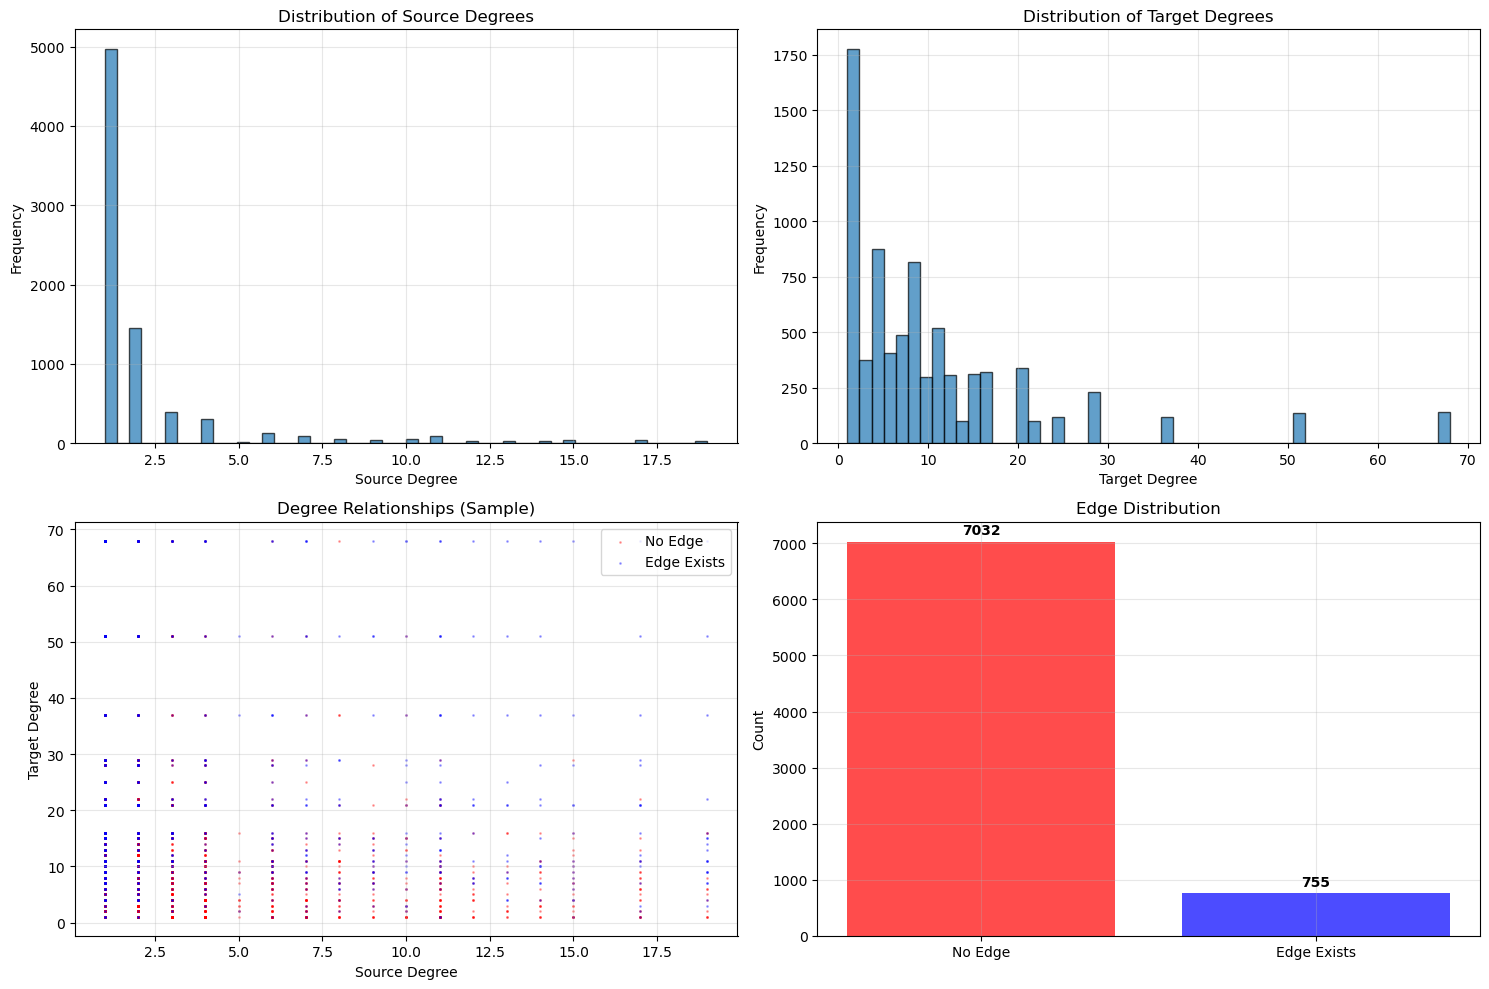

Data distribution visualized and saved.


In [5]:
# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Source degree distribution
axes[0, 0].hist(features[:, 0], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Source Degree')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Source Degrees')
axes[0, 0].grid(True, alpha=0.3)

# Target degree distribution
axes[0, 1].hist(features[:, 1], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Target Degree')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Target Degrees')
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot of degrees (colored by edge existence)
positive_mask = labels == 1
negative_mask = labels == 0

# Sample for visualization (too many points otherwise)
n_sample = min(10000, len(features))
sample_idx = np.random.choice(len(features), n_sample, replace=False)

axes[1, 0].scatter(features[sample_idx[negative_mask[sample_idx]], 0], 
                   features[sample_idx[negative_mask[sample_idx]], 1], 
                   alpha=0.3, s=1, label='No Edge', color='red')
axes[1, 0].scatter(features[sample_idx[positive_mask[sample_idx]], 0], 
                   features[sample_idx[positive_mask[sample_idx]], 1], 
                   alpha=0.3, s=1, label='Edge Exists', color='blue')
axes[1, 0].set_xlabel('Source Degree')
axes[1, 0].set_ylabel('Target Degree')
axes[1, 0].set_title('Degree Relationships (Sample)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Label distribution
label_counts = pd.Series(labels).value_counts().sort_index()
axes[1, 1].bar(['No Edge', 'Edge Exists'], label_counts.values, 
               color=['red', 'blue'], alpha=0.7)
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Edge Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Add count labels on bars
for i, count in enumerate(label_counts.values):
    axes[1, 1].text(i, count + len(features) * 0.01, str(count), 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / 'data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Data distribution visualized and saved.")

## 3. Empirical Frequency vs Analytical Comparison

In this section, we compare empirical frequencies with the analytical approximation formula:

$$P_{i,j} = \frac{u_i v_j}{\sqrt{(u_i v_j)^2 + (m - u_i - v_j + 1)^2}}$$

where $u_i$ is source degree, $v_j$ is target degree, and $m$ is total edges.

In [6]:
# Load and validate analytical approximation
# Use edge-type-specific empirical frequency file
EMPIRICAL_FREQ_FILE = repo_dir / 'results' / 'empirical_edge_frequencies' / f'edge_frequency_by_degree_{EDGE_TYPE}.csv'

print(f"Empirical frequency file: {EMPIRICAL_FREQ_FILE}")
print(f"File exists: {EMPIRICAL_FREQ_FILE.exists()}")

if EMPIRICAL_FREQ_FILE.exists():
    # Create evaluator for analytical validation
    evaluator = ModelEvaluator()
    
    # Load empirical frequency data
    empirical_df = evaluator.load_empirical_frequencies(str(EMPIRICAL_FREQ_FILE))
    
    # Extract degree combinations and frequencies
    source_degrees_empirical = empirical_df['source_degree'].values
    target_degrees_empirical = empirical_df['target_degree'].values
    empirical_frequencies = empirical_df['empirical_frequency'].values
    
    # Get total number of edges from the edge matrix
    total_edges_m = evaluator.get_total_edges_from_file(str(EDGE_FILE_PATH))
    
    # Validate analytical approximation against empirical frequencies
    validation_results = evaluator.validate_analytical_approximation_vs_empirical(
        source_degrees_empirical, target_degrees_empirical, empirical_frequencies, total_edges_m
    )
    
    print("\nAnalytical approximation validation completed!")
    
else:
    print("Empirical frequency file not found. Skipping analytical validation.")
    print("Run the edge frequency analysis first to generate the empirical frequencies.")
    validation_results = None

Empirical frequency file: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/empirical_edge_frequencies/edge_frequency_by_degree_CtD.csv
File exists: True
Loaded empirical frequencies from: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/empirical_edge_frequencies/edge_frequency_by_degree_CtD.csv
  Records: 408
  Source degree range: 1 - 19
  Target degree range: 1 - 68
  Frequency range: 0.001185 - 0.795000
Loaded edge matrix from /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/000.hetmat/edges/CtD.sparse.npz
  Shape: (1552, 137)
  Total edges: 755

Analytical Approximation Validation vs Empirical:
  Total edges (m): 755
  MAE vs Empirical: 0.018361
  RMSE vs Empirical: 0.030202
  R² vs Empirical: 0.970966
  Correlation vs Empirical: 0.989020
  Mean A

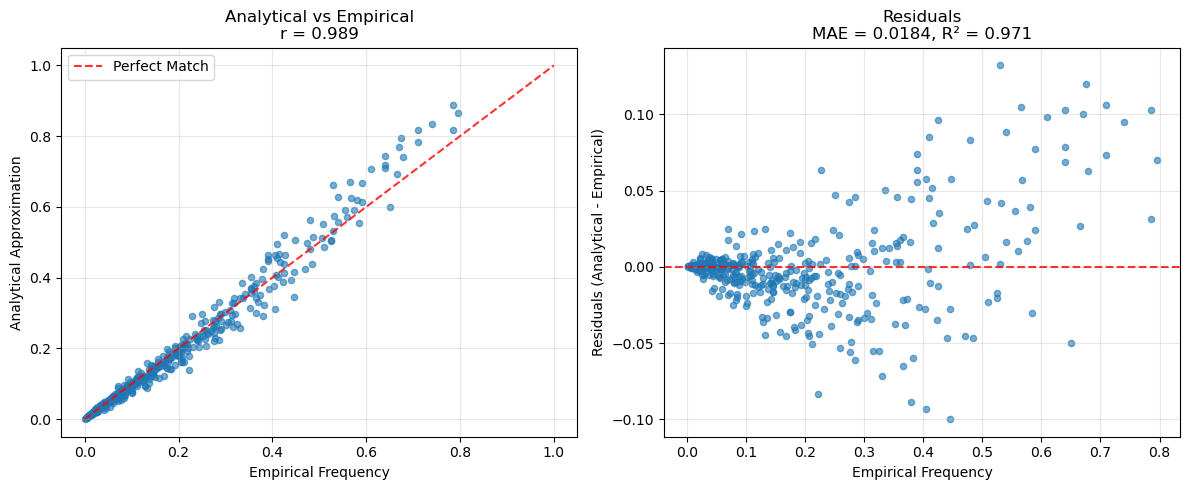

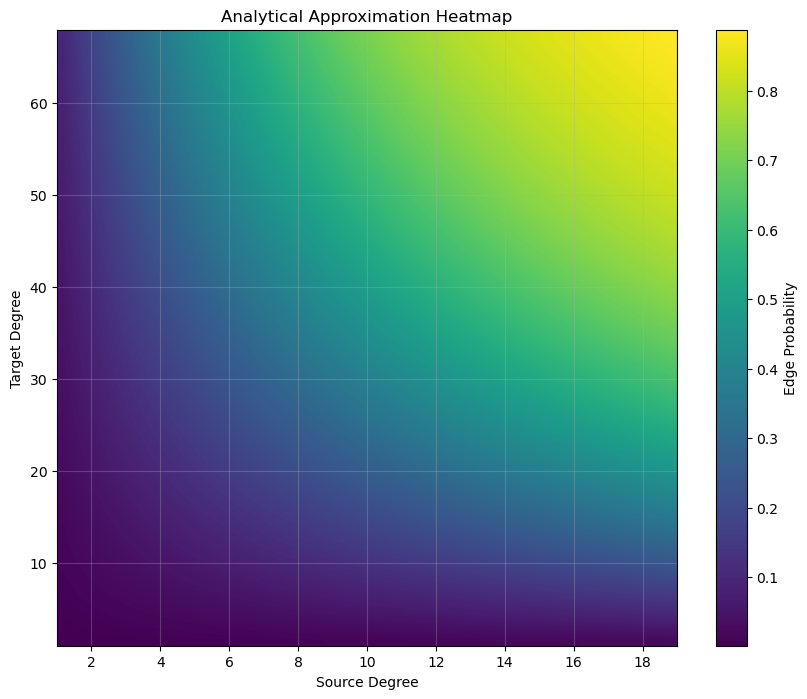

Analytical approximation validation visualizations created!


In [7]:
# Visualize analytical approximation validation (if available)
if validation_results is not None:
    # Create visualizer and plot analytical validation
    visualizer = ModelVisualizer()
    visualizer.plot_analytical_validation(
        validation_results, 
        save_path=results_dir / 'analytical_validation.png'
    )
    
    # Create degree grids for analytical heatmap visualization
    source_degrees_for_heatmap = features[:, 0]
    target_degrees_for_heatmap = features[:, 1]
    
    source_bins_analytical, target_bins_analytical, _ = create_degree_grid(
        source_degrees_for_heatmap, target_degrees_for_heatmap, n_bins=50
    )
    
    # Create analytical approximation heatmap
    visualizer.create_analytical_heatmap(
        source_bins_analytical, target_bins_analytical, validation_results['total_edges_m'],
        save_path=results_dir / 'analytical_heatmap.png'
    )
    
    print("Analytical approximation validation visualizations created!")
else:
    print("Skipping analytical validation visualizations - no validation data available.")

## 4. Model Training with Intelligent Parameter Adaptation

**Note**: The pipeline now includes **intelligent adaptation** based on dataset characteristics:

### Adaptive Sampling
- Automatically adjusts negative sampling ratio based on:
  - Dataset size (number of edges)
  - Edge density (% of possible edges that exist)
  - Mean node degrees
- Small, sparse datasets get more balanced sampling
- Large, dense datasets use sparse sampling

### Adaptive Random Forest
- **Hyperparameters automatically tuned** based on dataset complexity:
  - `n_estimators`: 20-100 trees
  - `max_depth`: 3-10 levels
  - `min_samples_split`: 50-2 samples
  - `min_samples_leaf`: 20-1 samples
- Prevents overfitting on small datasets like CtD
- Maintains high performance on large datasets like AeG

In [8]:
# Create all models with intelligent parameter adaptation
model_collection = ModelCollection(random_state=RANDOM_STATE)
models = model_collection.create_models(
    use_class_weights=True,
    input_dim=features.shape[1],  # Pass the correct input dimension
    edge_file_path=str(EDGE_FILE_PATH)  # Enable intelligent parameter adaptation
)
model_info = model_collection.get_model_info()

print("Models created:")
print("=" * 50)
for name, description in model_info.items():
    print(f"{name}:")
    print(f"  {description}")
    print()

print(f"Neural Network input dimension: {features.shape[1]} features")


  Zero-degree node filtering:
    Removed 1165 sources and 60 targets with degree=0
    Retained: 387 sources × 77 targets
    Density: 0.003551 → 0.025336 (7.1x increase)
  Tiny dataset detected (755 edges) - applying penalty factor 0.378
  Small dataset: Setting max_samples=0.8 for additional regularization

Adaptive Random Forest parameters:
  Dataset size: 755 edges, ~4088 training samples
  Complexity score: 0.170
    (size: 0.576, sparsity: 0.253, degree: 0.588)
  n_estimators: 25
  max_depth: 3 (→ max 8 leaves/tree)
  min_samples_split: 43
  min_samples_leaf: 25
  max_samples: 0.8
Models created:
Simple NN:
  High-performance Neural Network with 3 hidden layers (128, 64, 32 neurons), BatchNorm, Focal Loss, 2 features (source_degree, target_degree)

Random Forest:
  Random Forest Classifier with 25 trees, max_depth=3, min_samples_split=43, min_samples_leaf=25

Logistic Regression:
  Standard logistic regression with L2 regularization

Polynomial Logistic Regression:
  Polynomial

In [9]:
# Train all models
trainer = ModelTrainer(random_state=RANDOM_STATE)
training_results = trainer.train_all_models(
    models, features, labels, 
    test_size=TEST_SIZE, 
    val_size=VAL_SIZE
)

print("\nAll models trained successfully!")

TRAINING ALL MODELS
Total samples: 7787
Training samples: 6229 (NN uses 5606 for training, 623 for validation)
Test samples: 1558

Training Simple NN...
  Using Focal Loss (alpha=0.25, gamma=2.0)
  pos_weight=9.305 for class imbalance
  Class weights: Positive=5.153, Negative=0.554
  Positive samples: 544 (9.7%)
  Negative samples: 5062 (90.3%)
Training Neural Network:
  Training samples: 5606
  Validation samples: 623
  Batch size: 4096
  Max epochs: 60
  Epoch 10/60: Train Loss: 0.0564, Val Loss: 0.0348, Val Acc: 0.9069
  Epoch 20/60: Train Loss: 0.0332, Val Loss: 0.0254, Val Acc: 0.9069
  Epoch 30/60: Train Loss: 0.0285, Val Loss: 0.0240, Val Acc: 0.9117
  Early stopping at epoch 34
  Training completed in 1.54 seconds
  Best validation loss: 0.0239

Training Random Forest...
Training Random Forest:
  Training samples: 6229
  Training completed in 0.05 seconds

Training Logistic Regression...
Training Logistic Regression:
  Training samples: 6229
  Training completed in 0.00 seconds

## 5. Model Evaluation Statistics and Evaluation Visualizations

In [10]:
# Evaluate all models
evaluator = ModelEvaluator()
X_test = training_results['data_splits']['X_test']
y_test = training_results['data_splits']['y_test']

evaluation_results = evaluator.evaluate_all_models(training_results, X_test, y_test)

print("Model evaluation completed!")

EVALUATING ALL MODELS
Test samples: 1558
Positive samples: 151.0 (0.097)

Evaluating Simple NN...
  AUC: 0.8280
  Accuracy: 0.9082
  F1 Score: 0.1227
  RMSE: 0.2863
  Correlation: 0.4048

Evaluating Random Forest...
  AUC: 0.8429
  Accuracy: 0.9108
  F1 Score: 0.2320
  RMSE: 0.2632
  Correlation: 0.4713

Evaluating Logistic Regression...
  AUC: 0.8482
  Accuracy: 0.9140
  F1 Score: 0.3796
  RMSE: 0.2603
  Correlation: 0.4756

Evaluating Polynomial Logistic Regression...
  AUC: 0.8485
  Accuracy: 0.9121
  F1 Score: 0.2674
  RMSE: 0.2601
  Correlation: 0.4766

Model evaluation completed!


In [11]:
# Print detailed evaluation results
evaluator.print_detailed_results(evaluation_results)


DETAILED EVALUATION RESULTS

SIMPLE NN:
--------------------------------------------------
Test Samples: 1558
Positive Samples: 151.0 (9.7%)

Classification Metrics:
  AUC-ROC: 0.8280
  Accuracy: 0.9082
  Precision: 0.8333
  Recall/Sensitivity: 0.0662
  Specificity: 0.9986
  F1 Score: 0.1227
  Average Precision: 0.4380

Confusion Matrix:
  True Positives: 10
  False Positives: 2
  True Negatives: 1405
  False Negatives: 141

Regression Metrics:
  RMSE: 0.2863
  MAE: 0.2249
  R²: 0.0632
  Correlation: 0.4048

RANDOM FOREST:
--------------------------------------------------
Test Samples: 1558
Positive Samples: 151.0 (9.7%)

Classification Metrics:
  AUC-ROC: 0.8429
  Accuracy: 0.9108
  Precision: 0.7000
  Recall/Sensitivity: 0.1391
  Specificity: 0.9936
  F1 Score: 0.2320
  Average Precision: 0.4614

Confusion Matrix:
  True Positives: 21
  False Positives: 9
  True Negatives: 1398
  False Negatives: 130

Regression Metrics:
  RMSE: 0.2632
  MAE: 0.1466
  R²: 0.2085
  Correlation: 0.47

In [12]:
# Create and display comparison table
comparison_df = evaluator.create_comparison_dataframe(evaluation_results)
print("Model Performance Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Save comparison table
comparison_df.to_csv(results_dir / 'model_comparison.csv', index=False)
print(f"\nComparison table saved to: {results_dir / 'model_comparison.csv'}")

Model Performance Comparison:
                         Model    AUC  Accuracy  Precision  Recall  F1 Score  Average Precision   RMSE    MAE     R²  Correlation
Polynomial Logistic Regression 0.8485    0.9121     0.6944  0.1656    0.2674             0.4631 0.2601 0.1370 0.2270       0.4766
           Logistic Regression 0.8482    0.9140     0.6308  0.2715    0.3796             0.4800 0.2603 0.1394 0.2259       0.4756
                 Random Forest 0.8429    0.9108     0.7000  0.1391    0.2320             0.4614 0.2632 0.1466 0.2085       0.4713
                     Simple NN 0.8280    0.9082     0.8333  0.0662    0.1227             0.4380 0.2863 0.2249 0.0632       0.4048

Comparison table saved to: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/model_comparison/CtD_results/model_comparison.csv


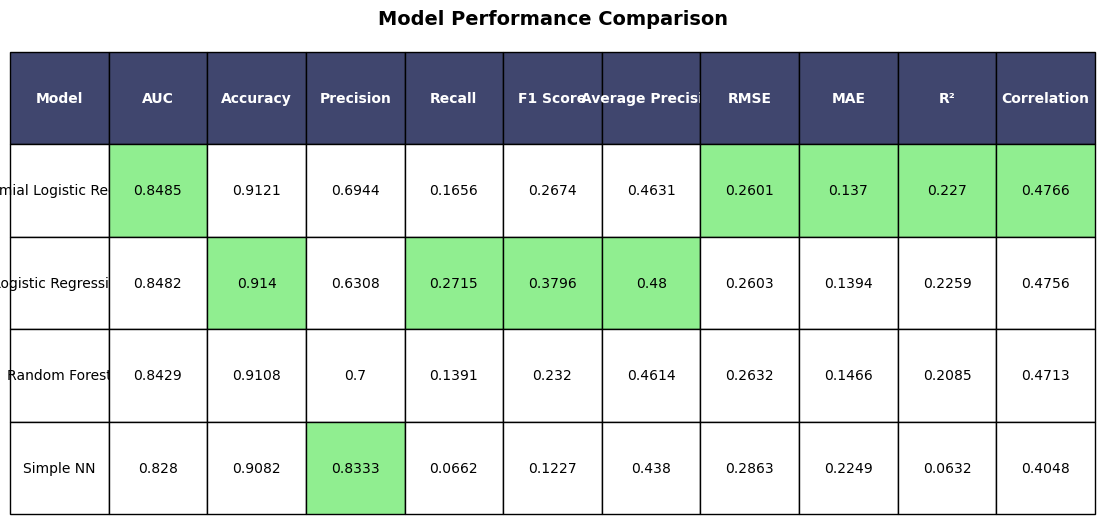

Creating ROC curves...


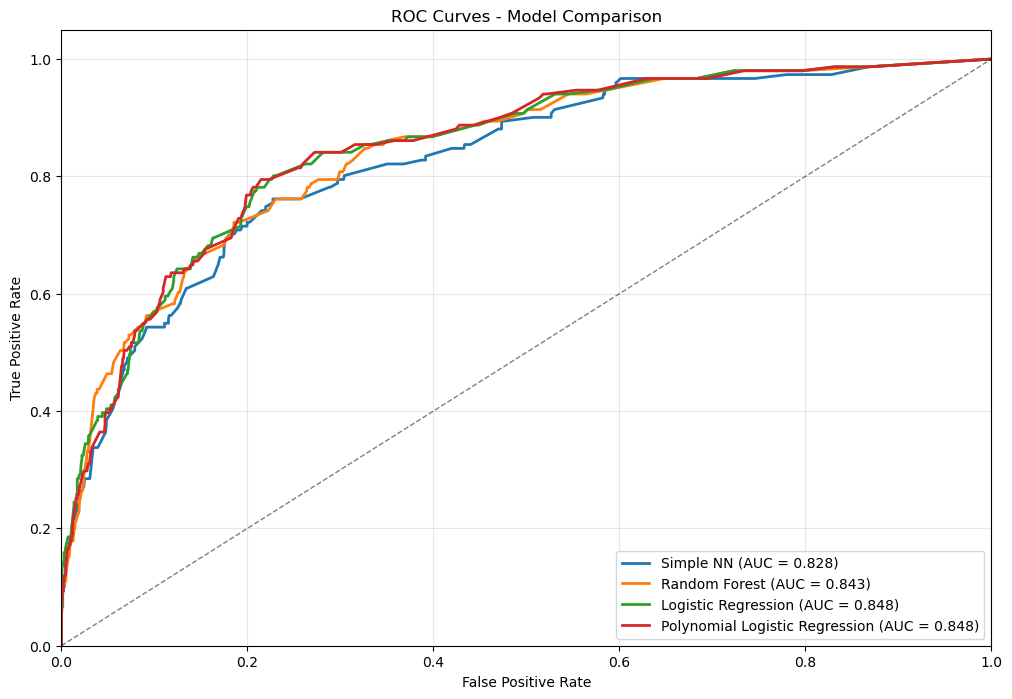

Creating Precision-Recall curves...


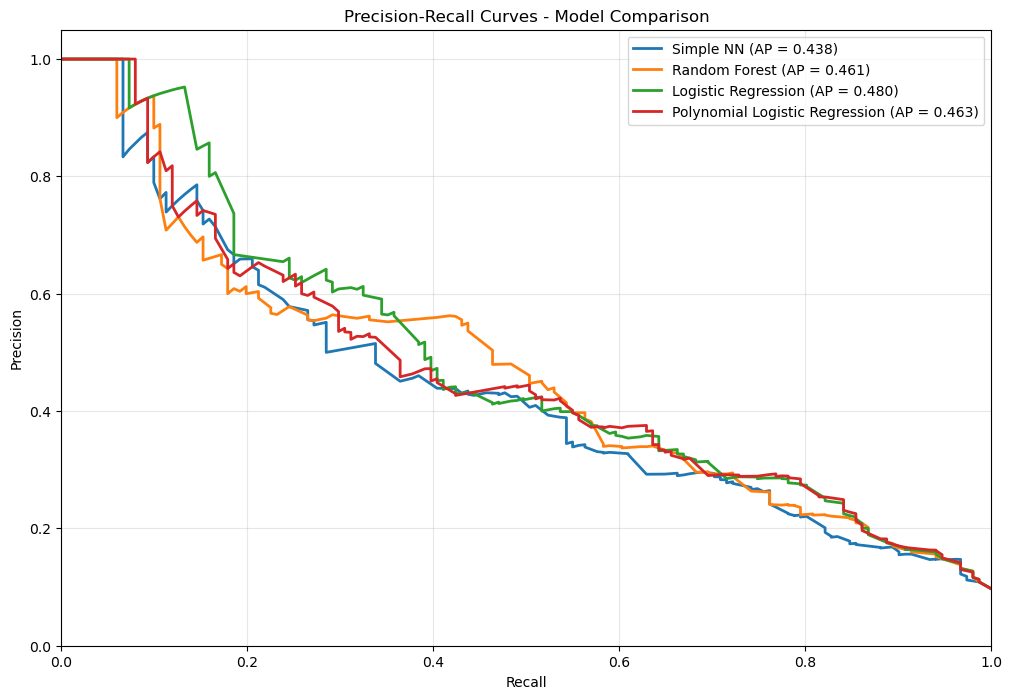

Creating performance comparison...


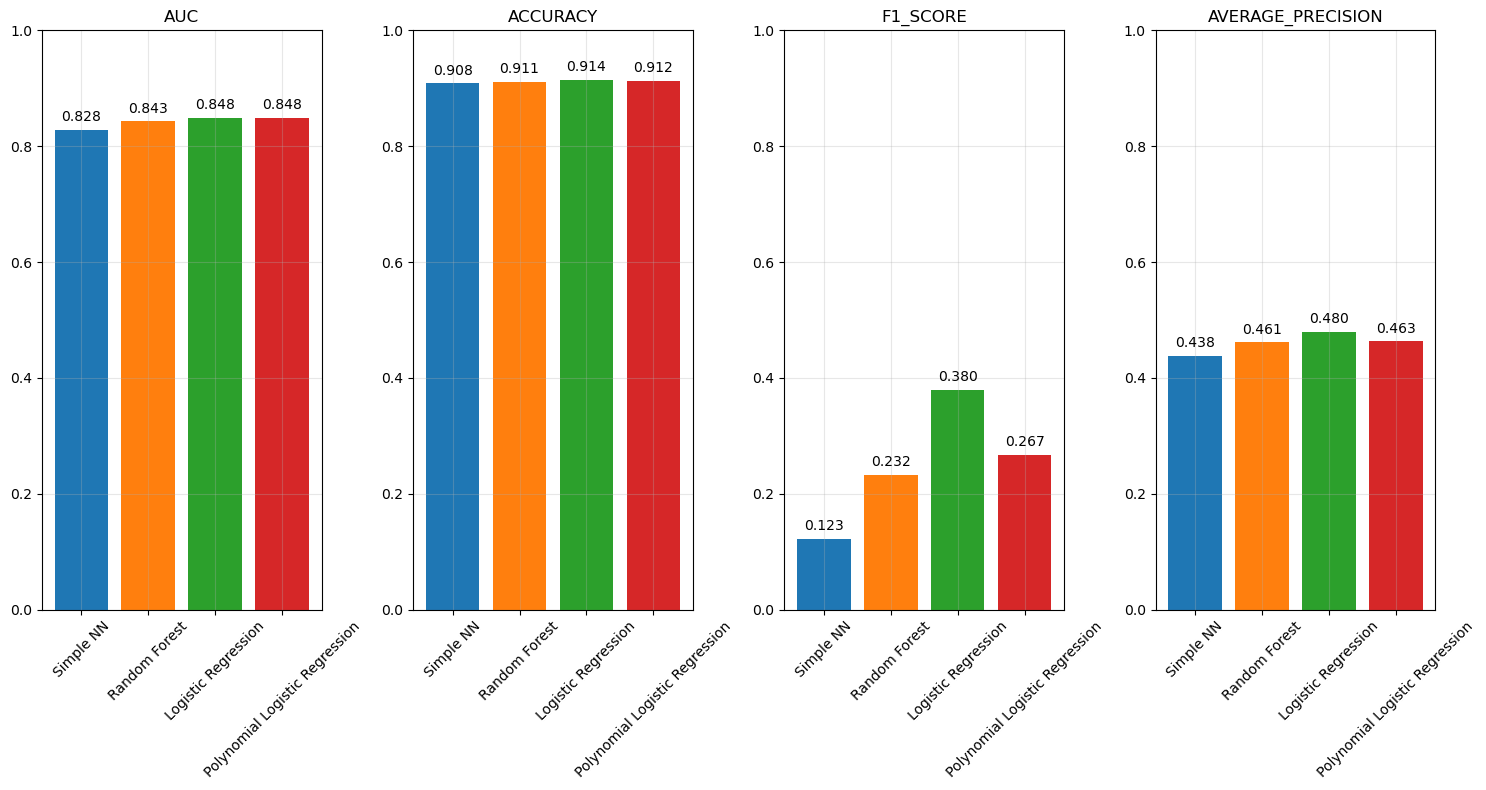

In [13]:
# Create visualizer and evaluation visualizations
visualizer = ModelVisualizer()

# Visual comparison table
create_comparison_table_plot(comparison_df, save_path=results_dir / 'comparison_table.png')

# Plot ROC curves
print("Creating ROC curves...")
visualizer.plot_roc_curves(evaluation_results, save_path=results_dir / 'roc_curves.png')

# Plot Precision-Recall curves
print("Creating Precision-Recall curves...")
visualizer.plot_precision_recall_curves(evaluation_results, save_path=results_dir / 'precision_recall_curves.png')

# Plot performance comparison
print("Creating performance comparison...")
visualizer.plot_performance_comparison(evaluation_results, save_path=results_dir / 'performance_comparison.png')

In [14]:
# Identify best models for each metric
best_models = get_best_models(evaluation_results)

print("Best Models by Metric:")
print("=" * 30)
for metric, model_name in best_models.items():
    print(f"{metric.upper():20}: {model_name}")

Best Models by Metric:
AUC                 : Polynomial Logistic Regression
ACCURACY            : Logistic Regression
F1_SCORE            : Logistic Regression
AVERAGE_PRECISION   : Logistic Regression
RMSE                : Polynomial Logistic Regression
CORRELATION         : Polynomial Logistic Regression


## 6. Model Edge Probability Heatmaps

In [15]:
# Create degree grids for heatmap visualization with enhanced features
source_degrees = features[:, 0]
target_degrees = features[:, 1]

# Load edge matrix for enhanced feature computation
edge_matrix = sp.load_npz(str(EDGE_FILE_PATH))
print(f"Loaded edge matrix: {edge_matrix.shape}")

# Use enhanced features if we trained with them
use_enhanced_features = features.shape[1] > 2
print(f"Using enhanced features for heatmaps: {use_enhanced_features}")

source_bins, target_bins, grid_features = create_degree_grid(
    source_degrees, target_degrees, n_bins=50,
    enhanced_features=use_enhanced_features,
    edge_matrix=edge_matrix if use_enhanced_features else None
)

print(f"Created degree grid for visualization:")
print(f"  Source degree range: {source_bins.min():.0f} - {source_bins.max():.0f}")
print(f"  Target degree range: {target_bins.min():.0f} - {target_bins.max():.0f}")
print(f"  Grid size: {len(source_bins)} x {len(target_bins)} = {len(grid_features)} points")
print(f"  Grid features shape: {grid_features.shape}")
if use_enhanced_features:
    print(f"  Enhanced features: {grid_features.shape[1]} features per grid point")

Loaded edge matrix: (1552, 137)
Using enhanced features for heatmaps: False
Created degree grid for visualization:
  Source degree range: 1 - 19
  Target degree range: 1 - 68
  Grid size: 50 x 50 = 2500 points
  Grid features shape: (2500, 2)


Creating individual prediction heatmaps...
Creating prediction heatmaps for all models...
Creating heatmap for Simple NN...


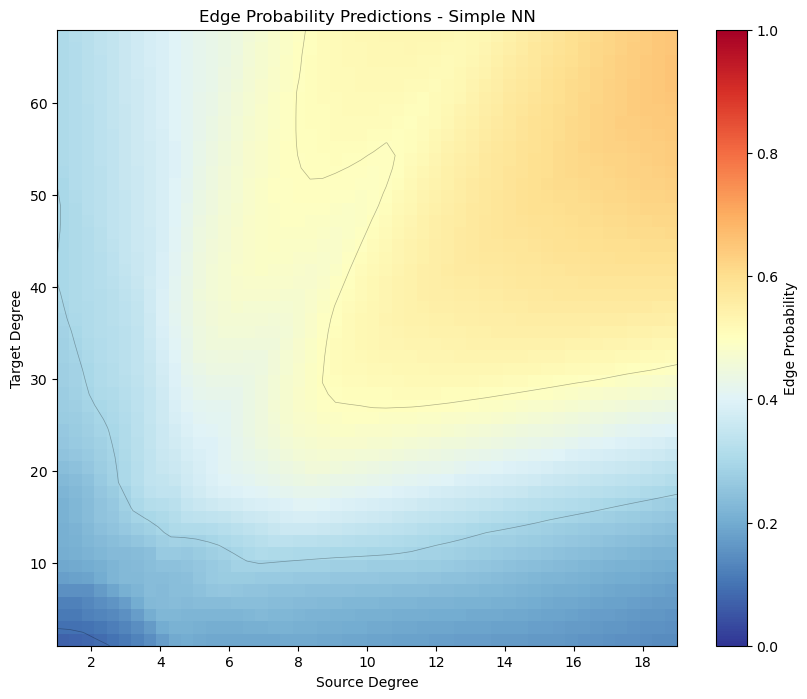

Creating heatmap for Random Forest...


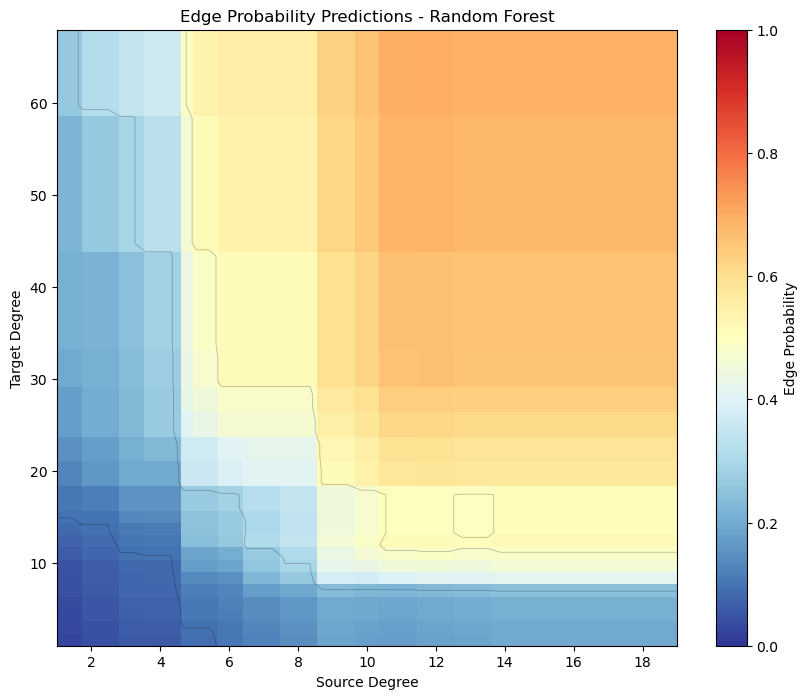

Creating heatmap for Logistic Regression...


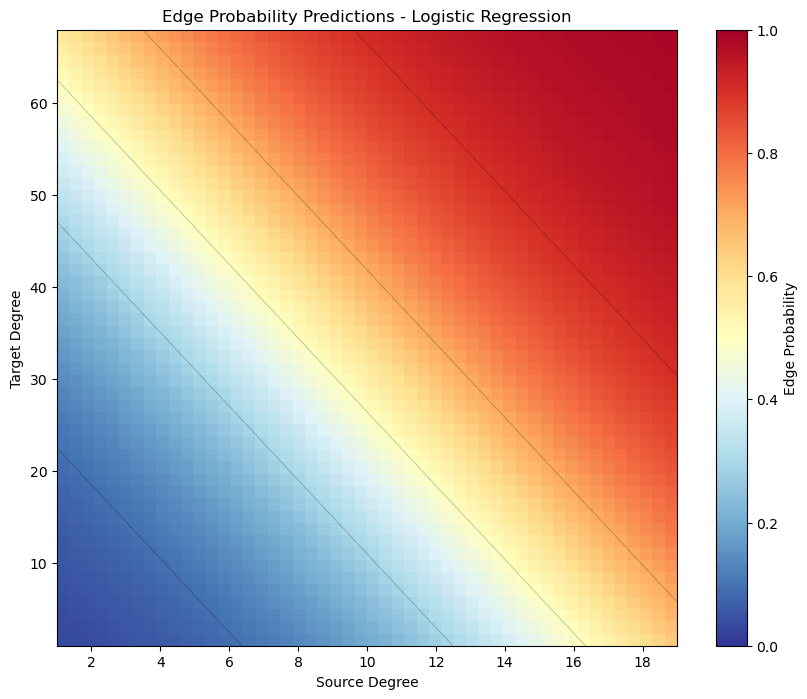

Creating heatmap for Polynomial Logistic Regression...


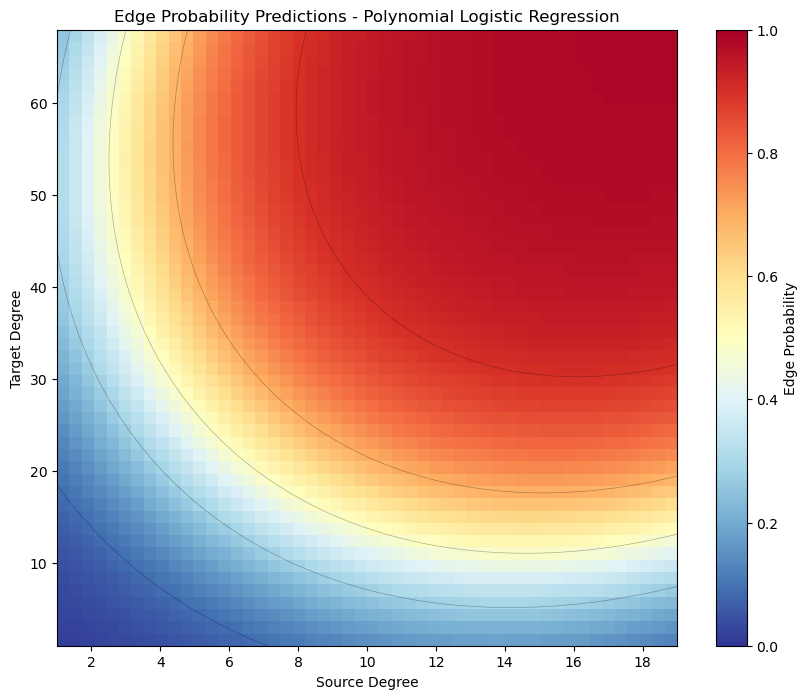

In [16]:
# Create individual heatmaps for each model
print("Creating individual prediction heatmaps...")
visualizer.create_all_prediction_heatmaps(
    training_results, source_bins, target_bins, 
    save_dir=str(results_dir),
    grid_features=grid_features  # Pass the enhanced features we created
)

## 7. Model Predictions vs Analytical

In [17]:
# Compare all model predictions with analytical approximation
analytical_comparison = evaluator.compare_models_vs_analytical_approximation(
    evaluation_results, training_results, X_test, str(EDGE_FILE_PATH)
)

# Print summary of analytical comparison
evaluator.print_analytical_comparison_summary(analytical_comparison)

# Create comparison dataframe
analytical_df = evaluator.create_analytical_comparison_dataframe(analytical_comparison)
print("\nModel Predictions vs Analytical Approximation:")
print("=" * 80)
print(analytical_df.to_string(index=False, float_format='%.6f'))

# Save analytical comparison results
analytical_df.to_csv(results_dir / 'models_vs_analytical_comparison.csv', index=False)
print(f"\nAnalytical comparison saved to: {results_dir / 'models_vs_analytical_comparison.csv'}")

Loaded edge matrix from /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/000.hetmat/edges/CtD.sparse.npz
  Shape: (1552, 137)
  Total edges: 755

COMPARING MODEL PREDICTIONS WITH ANALYTICAL APPROXIMATION
Total edges (m): 755
Test samples: 1558

Comparing Simple NN with analytical approximation...
  MAE vs Analytical: 0.152051
  RMSE vs Analytical: 0.161435
  R² vs Analytical: -3.421707
  Correlation vs Analytical: 0.710846

Comparing Random Forest with analytical approximation...
  MAE vs Analytical: 0.064257
  RMSE vs Analytical: 0.081357
  R² vs Analytical: -0.123024
  Correlation vs Analytical: 0.889112

Comparing Logistic Regression with analytical approximation...
  MAE vs Analytical: 0.067347
  RMSE vs Analytical: 0.108385
  R² vs Analytical: -0.993132
  Correlation vs Analytical: 0.853700

Comparing Polynomial Logistic Regression with analytical approximation...
  MAE vs Analytical: 0.063957
  

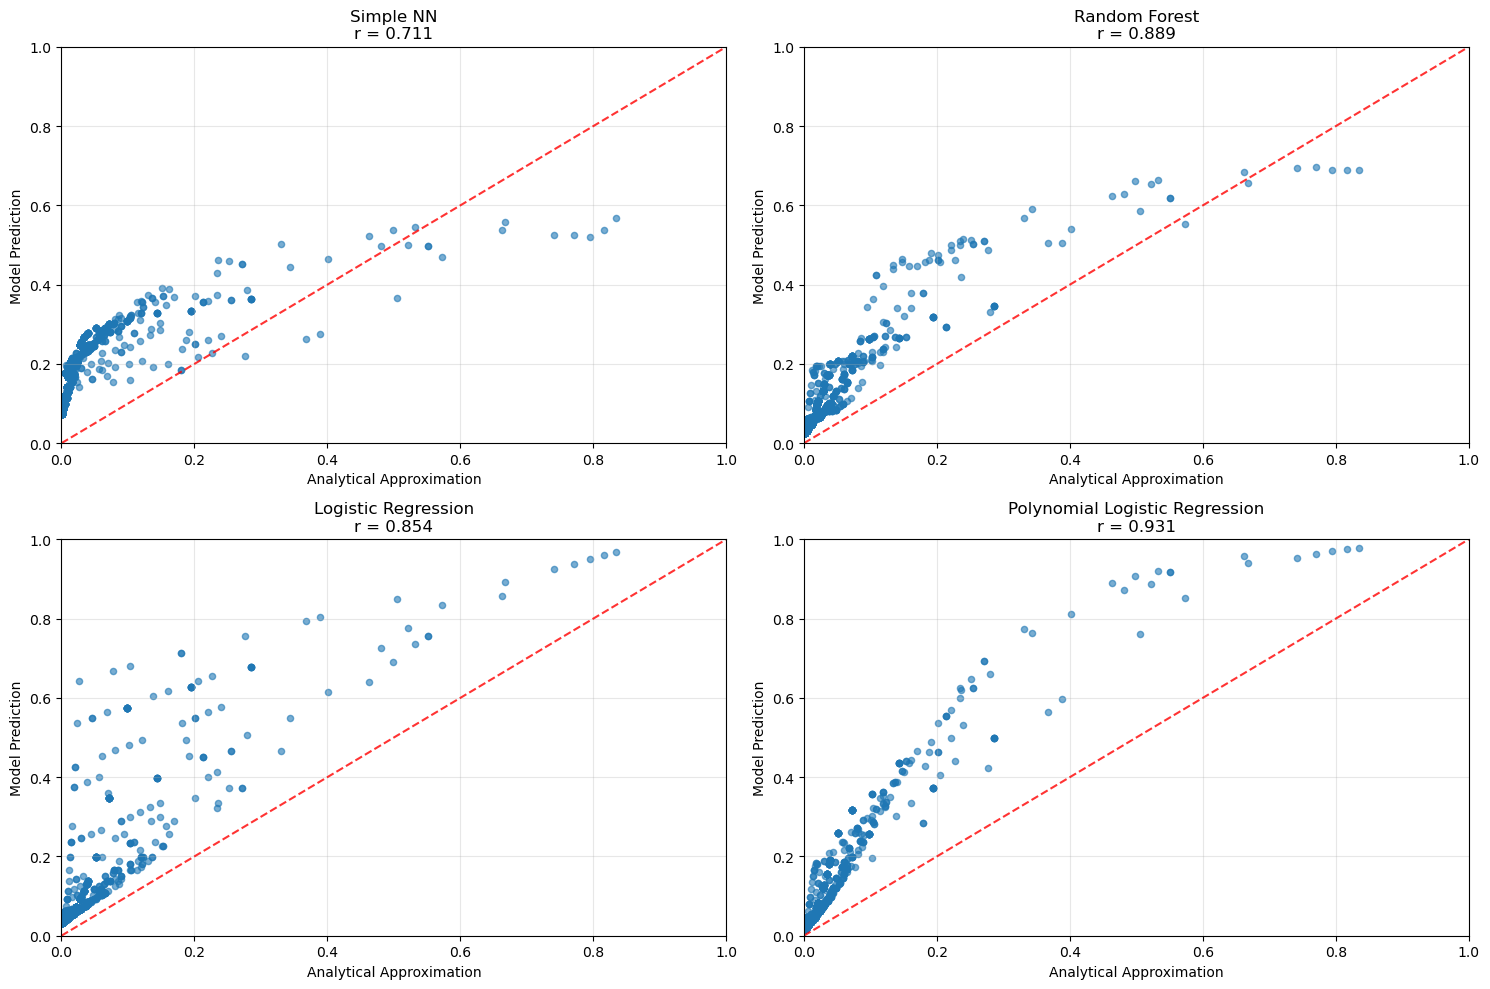

Model predictions vs analytical approximation plots created!


In [18]:
# Visualize model predictions vs analytical approximation
visualizer.plot_models_vs_analytical_comparison(
    analytical_comparison,
    save_path=results_dir / 'models_vs_analytical_scatter.png'
)

print("Model predictions vs analytical approximation plots created!")

## 8. Model Predictions vs Empirical

In [19]:
# Test Predictions vs Empirical Frequencies Comparison
if EMPIRICAL_FREQ_FILE.exists():
    # Compare test predictions with empirical frequencies for the same degree combinations
    test_empirical_comparison = evaluator.compare_test_predictions_with_empirical(
        evaluation_results, training_results, X_test, str(EMPIRICAL_FREQ_FILE)
    )
    
    # Print summary
    evaluator.print_test_empirical_comparison_summary(test_empirical_comparison)
    
    # Create comparison dataframe
    test_empirical_df = evaluator.create_test_empirical_comparison_dataframe(test_empirical_comparison)
    print("\nTest Predictions vs Empirical Frequencies Comparison:")
    print("=" * 80)
    print(test_empirical_df.to_string(index=False, float_format='%.6f'))
    
    # Save comparison results
    test_empirical_df.to_csv(results_dir / 'test_vs_empirical_comparison.csv', index=False)
    print(f"\nTest vs empirical comparison saved to: {results_dir / 'test_vs_empirical_comparison.csv'}")
    
else:
    print("Empirical frequency file not found. Skipping empirical comparison.")
    print("Run the edge frequency analysis first to generate the empirical frequencies.")
    test_empirical_comparison = None
    test_empirical_df = None

Loaded empirical frequencies from: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/empirical_edge_frequencies/edge_frequency_by_degree_CtD.csv
  Records: 408
  Source degree range: 1 - 19
  Target degree range: 1 - 68
  Frequency range: 0.001185 - 0.795000

COMPARING TEST PREDICTIONS WITH EMPIRICAL FREQUENCIES

Comparing Simple NN test predictions with empirical frequencies...
  Matched degree combinations: 1558/1558 (100.0%)
  MAE vs Empirical: 0.151906
  RMSE vs Empirical: 0.161359
  R² vs Empirical: -3.887471
  Correlation vs Empirical: 0.716996

Comparing Random Forest test predictions with empirical frequencies...
  Matched degree combinations: 1558/1558 (100.0%)
  MAE vs Empirical: 0.064220
  RMSE vs Empirical: 0.080502
  R² vs Empirical: -0.216509
  Correlation vs Empirical: 0.911872

Comparing Logistic Regression test predictions with empirical frequencies...
  Matched degree combinations: 1558/1558 (1

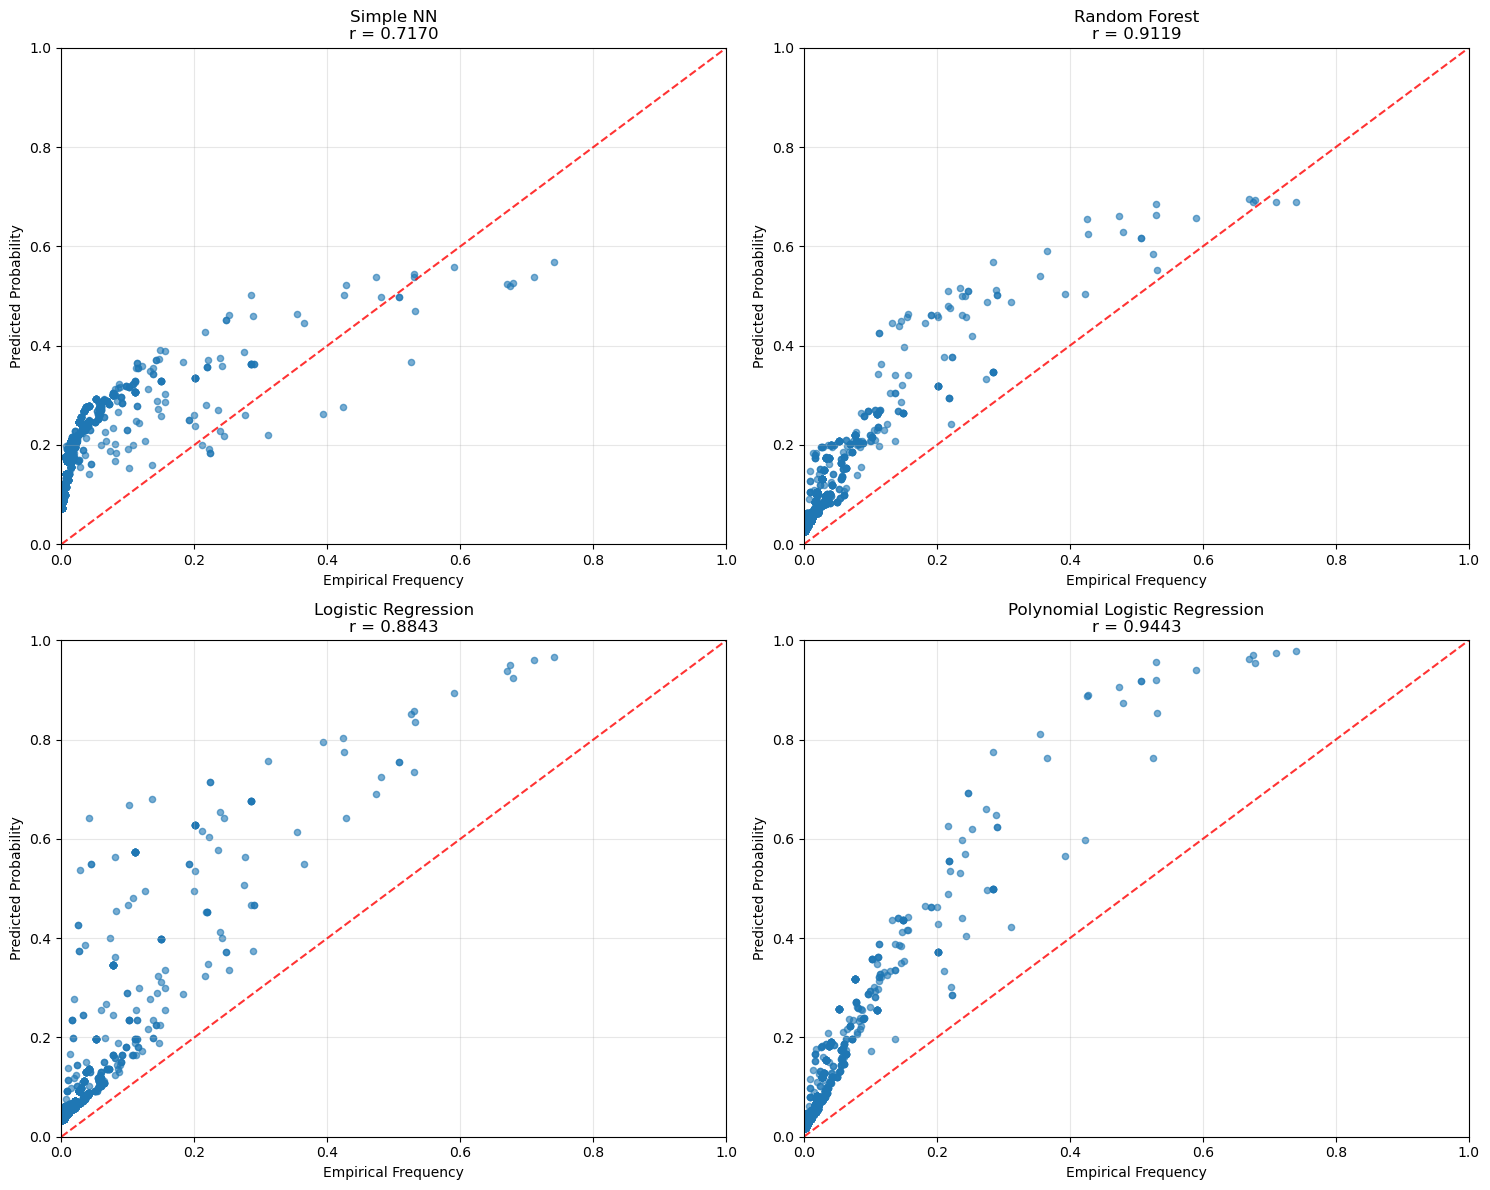

Test vs empirical scatter plots created!


In [20]:
# Create scatter plot comparing predictions vs empirical frequencies
if test_empirical_comparison is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (model_name, results) in enumerate(test_empirical_comparison.items()):
        if i >= 4:  # Only plot first 4 models
            break
            
        predictions = results['matched_predictions']
        empirical = results['matched_empirical']
        correlation = results['correlation_vs_empirical']
        
        axes[i].scatter(empirical, predictions, alpha=0.6, s=20)
        axes[i].plot([0, 1], [0, 1], 'r--', alpha=0.8)  # Perfect correlation line
        axes[i].set_xlabel('Empirical Frequency')
        axes[i].set_ylabel('Predicted Probability')
        axes[i].set_title(f'{model_name}\nr = {correlation:.4f}')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(results_dir / 'test_vs_empirical_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Test vs empirical scatter plots created!")

## 9. Enhanced Scatter Plots Colored by Node Features

This section implements scatter plots colored by:
- Source degree
- Target degree 
- Source × Target degree

These visualizations help understand how model predictions relate to different node characteristics.

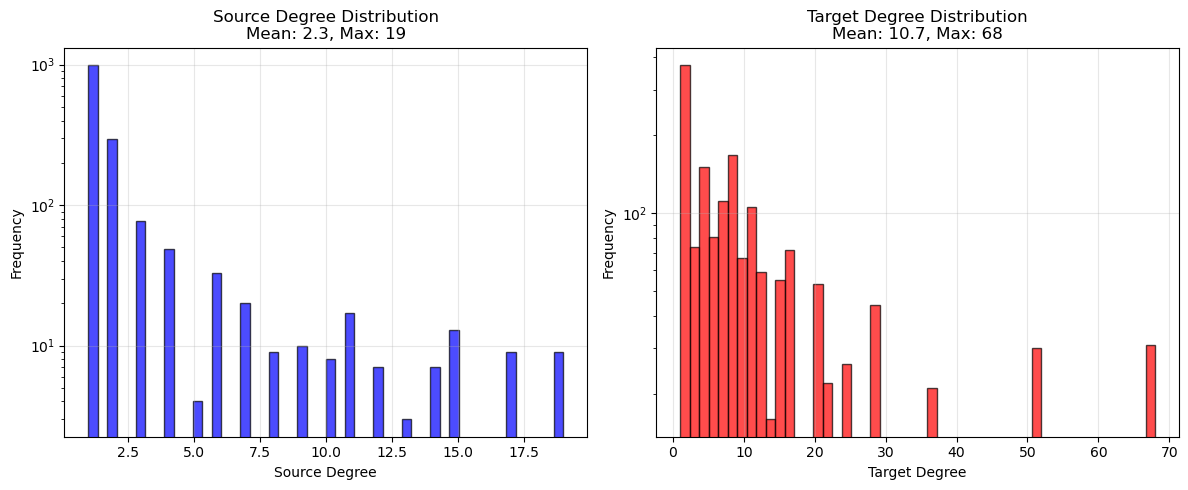

Test set degree statistics:
  Source degrees: 1 - 19 (mean: 2.3)
  Target degrees: 1 - 68 (mean: 10.7)


In [21]:
# Extract degree information for coloring
test_source_degrees = X_test[:, 0]
test_target_degrees = X_test[:, 1]

# Plot degree distributions for context
plot_degree_distribution_comparison(
    test_source_degrees, test_target_degrees,
    save_path=results_dir / 'test_degree_distributions.png'
)

print(f"Test set degree statistics:")
print(f"  Source degrees: {test_source_degrees.min():.0f} - {test_source_degrees.max():.0f} (mean: {test_source_degrees.mean():.1f})")
print(f"  Target degrees: {test_target_degrees.min():.0f} - {test_target_degrees.max():.0f} (mean: {test_target_degrees.mean():.1f})")

In [22]:
# Create model predictions dictionary for coloring
# Import prediction function
from model_training import predict_with_model

model_predictions_dict = {}
for model_name, model_result in training_results.items():
    if model_name == 'data_splits':
        continue
    
    model = model_result['model']
    scaler = model_result['training_result'].get('scaler')
    predictions = predict_with_model(model, X_test, model_name, scaler)
    model_predictions_dict[model_name] = predictions

print(f"Generated predictions for {len(model_predictions_dict)} models")

# Use empirical frequencies if available, otherwise use y_test as ground truth
if test_empirical_comparison is not None:
    print("Using properly matched empirical data from test_empirical_comparison")
    
    # Get the matched data from the first model (they should all have the same empirical values)
    first_model_results = list(test_empirical_comparison.values())[0]
    reference_values = first_model_results['matched_empirical']
    
    # Use the matched predictions from each model instead of truncating
    model_predictions_truncated = {}
    for model_name in model_predictions_dict.keys():
        if model_name in test_empirical_comparison:
            model_predictions_truncated[model_name] = test_empirical_comparison[model_name]['matched_predictions']
        else:
            # Fallback if model not found
            model_predictions_truncated[model_name] = model_predictions_dict[model_name][:len(reference_values)]
    
    # CRITICAL FIX: Reconstruct the actual degree combinations that were matched
    # Load the empirical frequency data to recreate the matching process
    empirical_df = pd.read_csv(str(EMPIRICAL_FREQ_FILE))
    
    # Create the same lookup dictionary used in model_evaluation.py
    # FIX: Use 'frequency' column name, not 'empirical_frequency'
    empirical_lookup = {}
    for _, row in empirical_df.iterrows():
        key = (int(row['source_degree']), int(row['target_degree']))
        empirical_lookup[key] = row['frequency']  # FIXED: Use correct column name
    
    # Recreate the matching process to get the exact degree combinations
    matched_source_degrees = []
    matched_target_degrees = []
    matched_empirical_check = []
    
    for i, (source_deg, target_deg) in enumerate(X_test):
        key = (int(source_deg), int(target_deg))
        if key in empirical_lookup:
            matched_source_degrees.append(source_deg)
            matched_target_degrees.append(target_deg)
            matched_empirical_check.append(empirical_lookup[key])
    
    # Convert to numpy arrays
    source_degrees_for_coloring = np.array(matched_source_degrees)
    target_degrees_for_coloring = np.array(matched_target_degrees)
    matched_empirical_check = np.array(matched_empirical_check)
    
    # Verify our reconstruction matches the empirical comparison
    if len(source_degrees_for_coloring) == len(reference_values):
        if np.allclose(matched_empirical_check, reference_values, rtol=1e-10):
            print("✓ Perfect match: Reconstructed degree combinations match empirical data exactly!")
        else:
            print("⚠ Warning: Reconstructed empirical values don't match perfectly")
            print(f"  Max difference: {np.max(np.abs(matched_empirical_check - reference_values))}")
    else:
        print(f"⚠ Length mismatch: {len(source_degrees_for_coloring)} reconstructed vs {len(reference_values)} reference")
    
    reference_label = "Empirical Frequency"
    print(f"Using empirical frequencies as reference ({len(reference_values)} points)")
    print(f"Degree ranges - Source: {source_degrees_for_coloring.min():.0f}-{source_degrees_for_coloring.max():.0f}, Target: {target_degrees_for_coloring.min():.0f}-{target_degrees_for_coloring.max():.0f}")
    print(f"Degree product range: {(source_degrees_for_coloring * target_degrees_for_coloring).min():.0f}-{(source_degrees_for_coloring * target_degrees_for_coloring).max():.0f}")
    
else:
    reference_values = y_test
    model_predictions_truncated = model_predictions_dict
    source_degrees_for_coloring = test_source_degrees
    target_degrees_for_coloring = test_target_degrees
    reference_label = "Ground Truth"
    print(f"Using test labels as reference ({len(reference_values)} points)")

Generated predictions for 4 models
Using properly matched empirical data from test_empirical_comparison
✓ Perfect match: Reconstructed degree combinations match empirical data exactly!
Using empirical frequencies as reference (1558 points)
Degree ranges - Source: 1-19, Target: 1-68
Degree product range: 1-1020


Creating scatter plots colored by source degree...


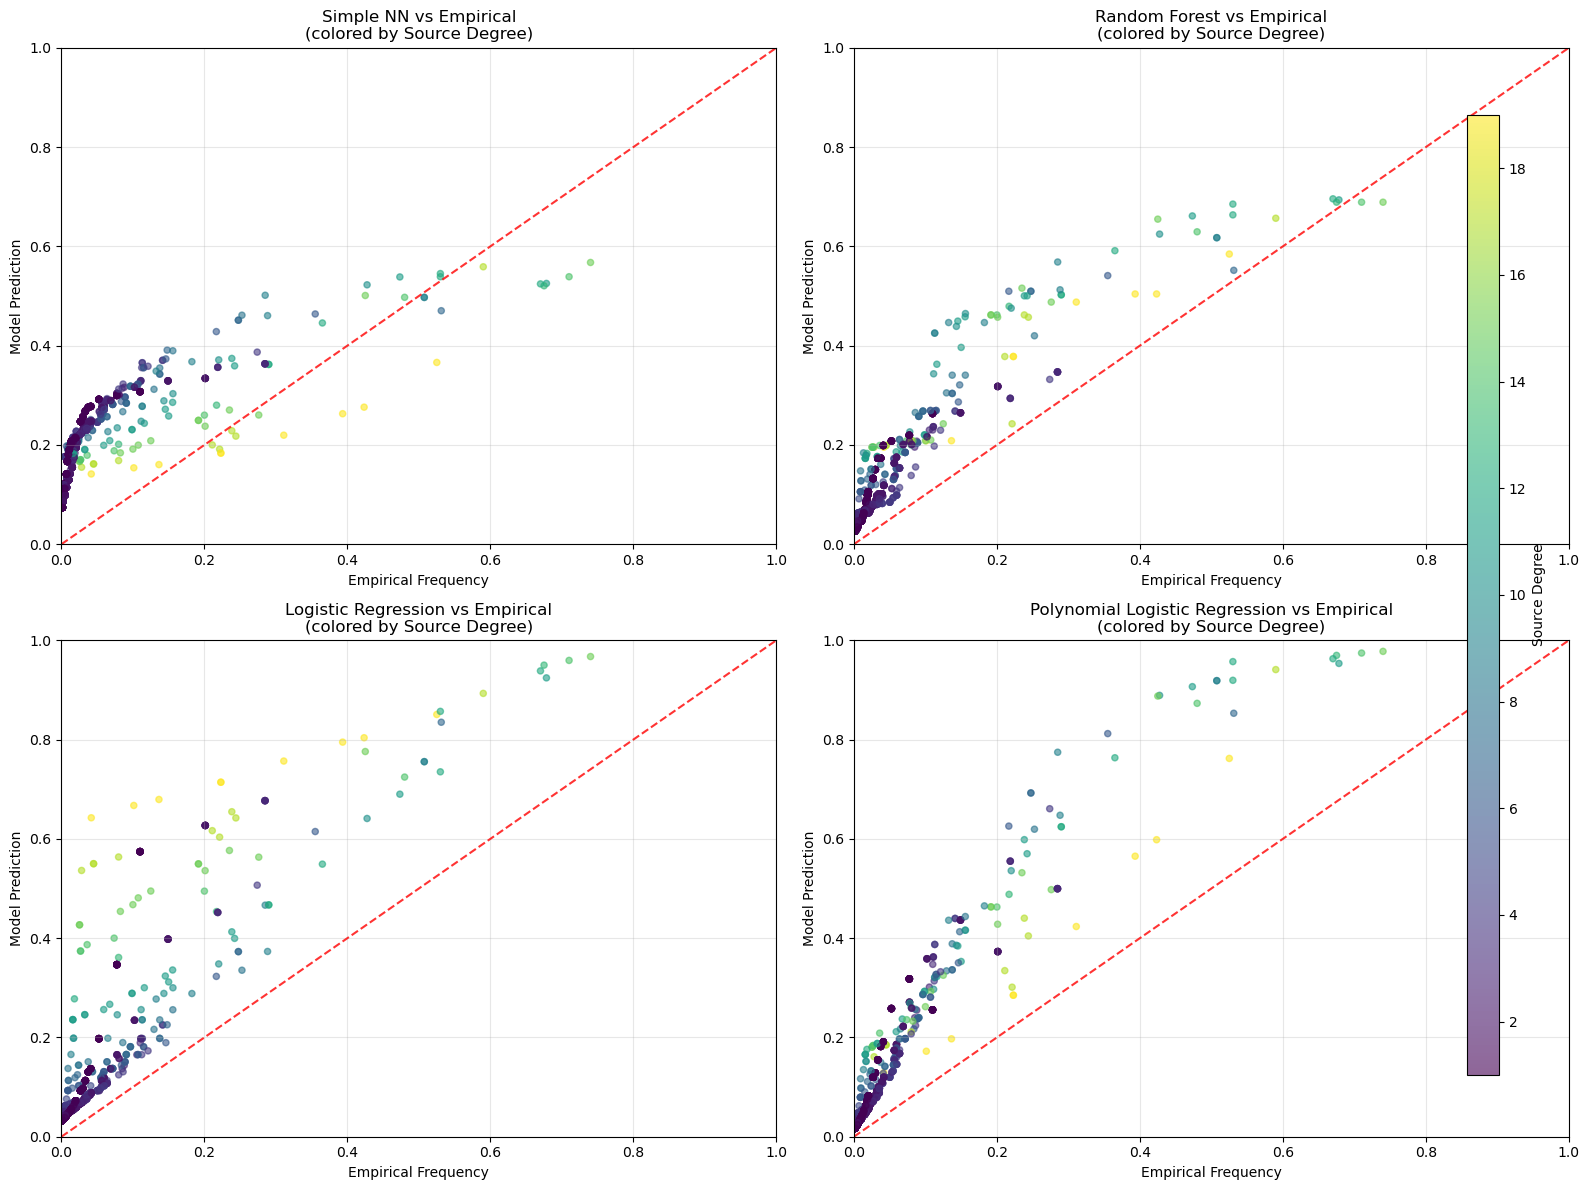

Scatter plots colored by source degree created!


In [23]:
# Create scatter plots colored by source degree
print("Creating scatter plots colored by source degree...")
create_model_comparison_grid_with_coloring(
    model_predictions_truncated, reference_values,
    source_degrees_for_coloring, target_degrees_for_coloring,
    color_by='source_degree',
    figsize=(16, 12),
    save_path=results_dir / 'models_colored_by_source_degree.png'
)

print("Scatter plots colored by source degree created!")

Creating scatter plots colored by target degree...


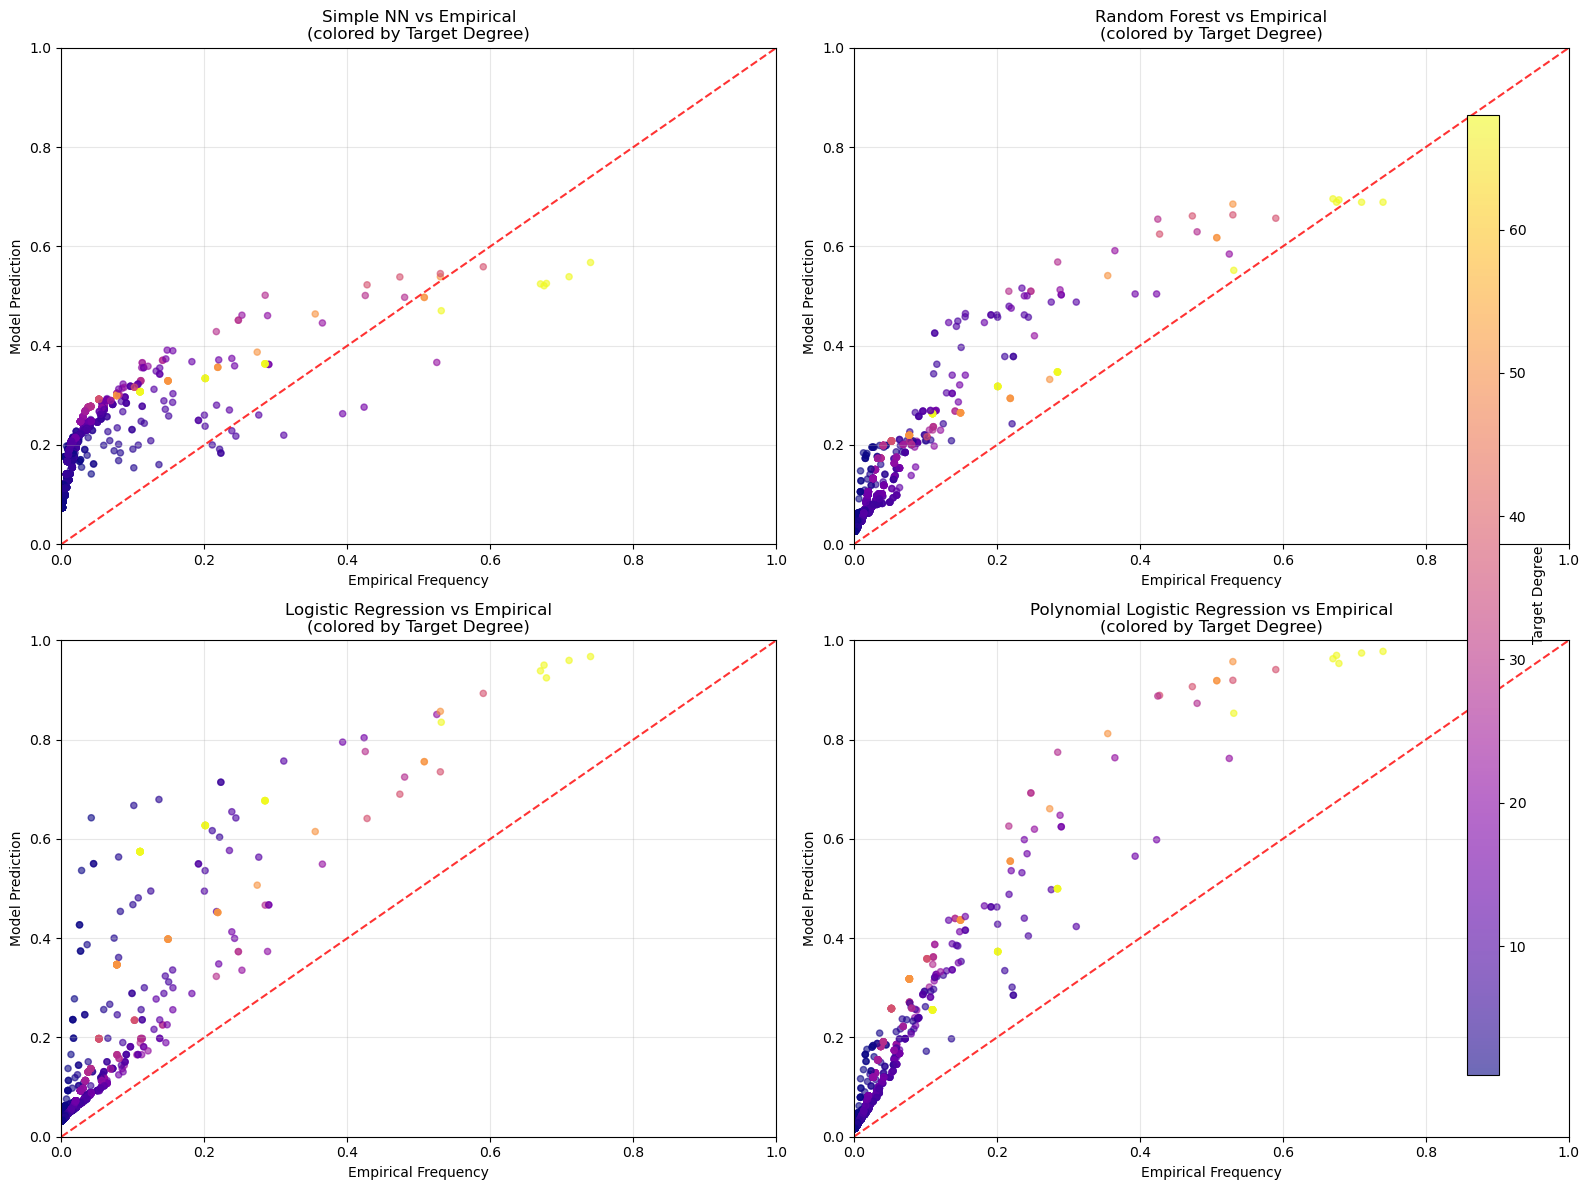

Scatter plots colored by target degree created!


In [24]:
# Create scatter plots colored by target degree
print("Creating scatter plots colored by target degree...")
create_model_comparison_grid_with_coloring(
    model_predictions_truncated, reference_values,
    source_degrees_for_coloring, target_degrees_for_coloring,
    color_by='target_degree',
    figsize=(16, 12),
    save_path=results_dir / 'models_colored_by_target_degree.png'
)

print("Scatter plots colored by target degree created!")

Creating scatter plots colored by degree product...


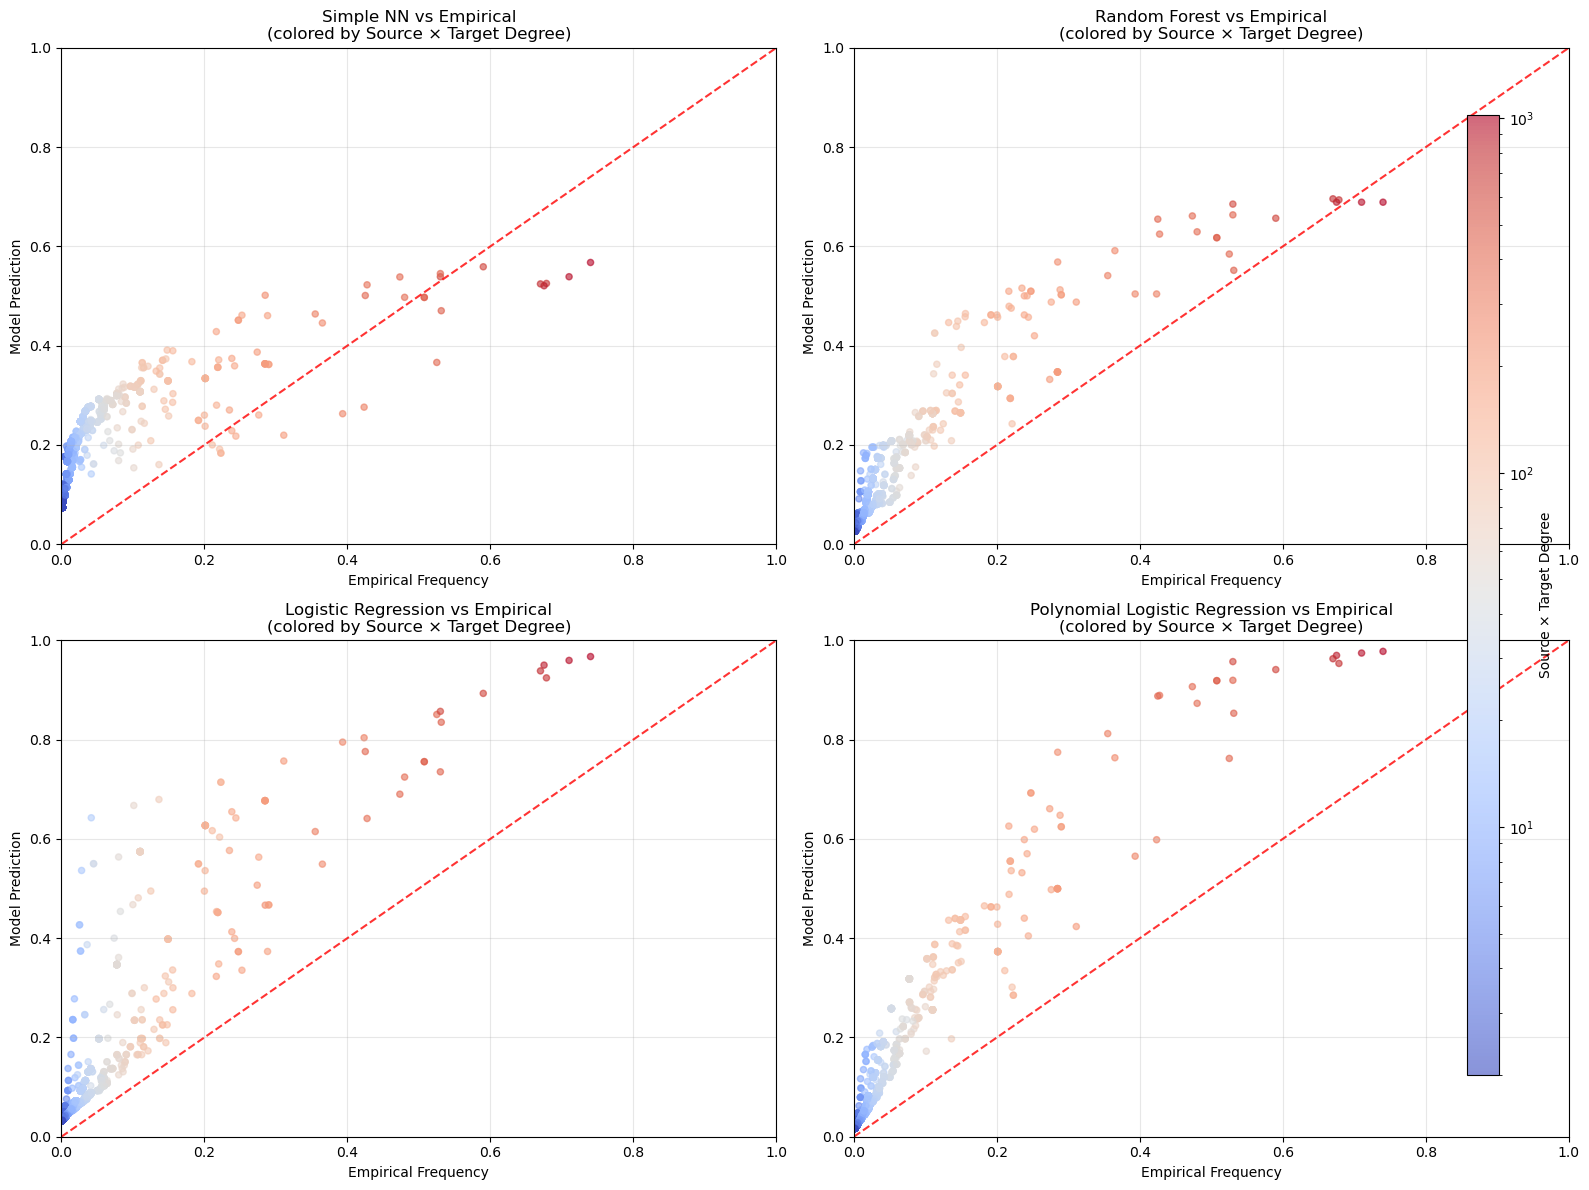

Scatter plots colored by degree product created!


In [25]:
# Create scatter plots colored by source × target degree product
print("Creating scatter plots colored by degree product...")
create_model_comparison_grid_with_coloring(
    model_predictions_truncated, reference_values,
    source_degrees_for_coloring, target_degrees_for_coloring,
    color_by='degree_product',
    figsize=(16, 12),
    save_path=results_dir / 'models_colored_by_degree_product.png'
)

print("Scatter plots colored by degree product created!")

Using model with best empirical correlation: Polynomial Logistic Regression
Creating detailed colored scatter plots for best model: Polynomial Logistic Regression


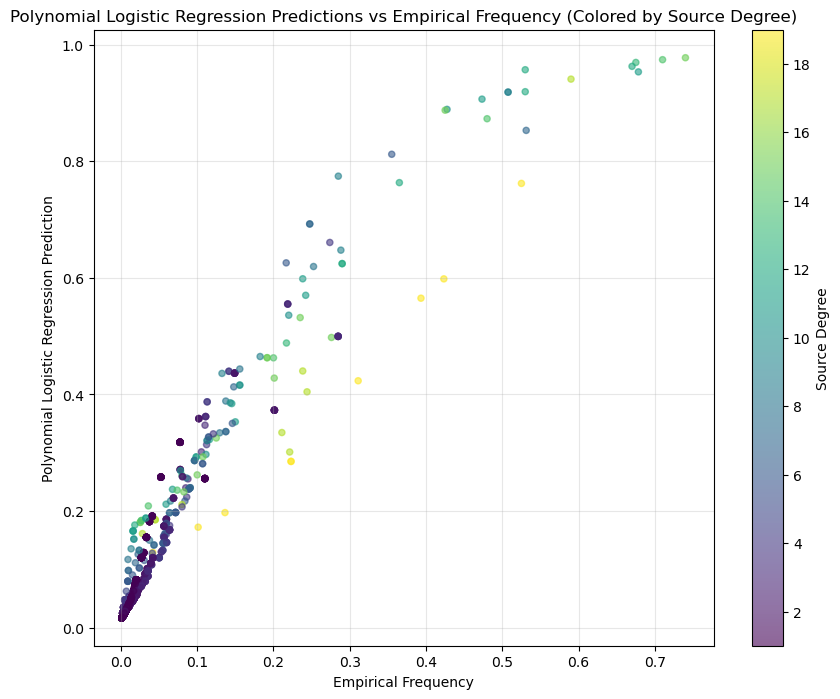

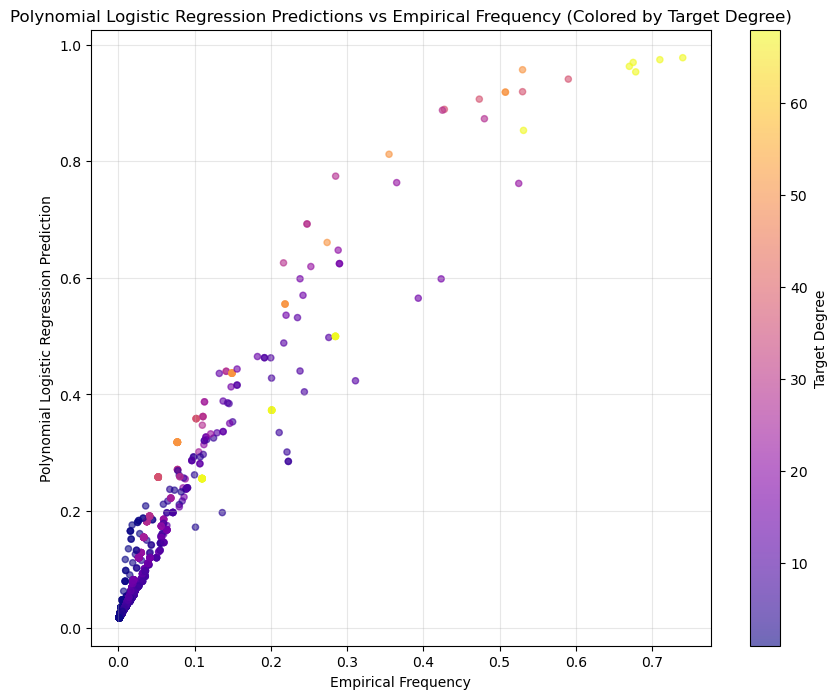

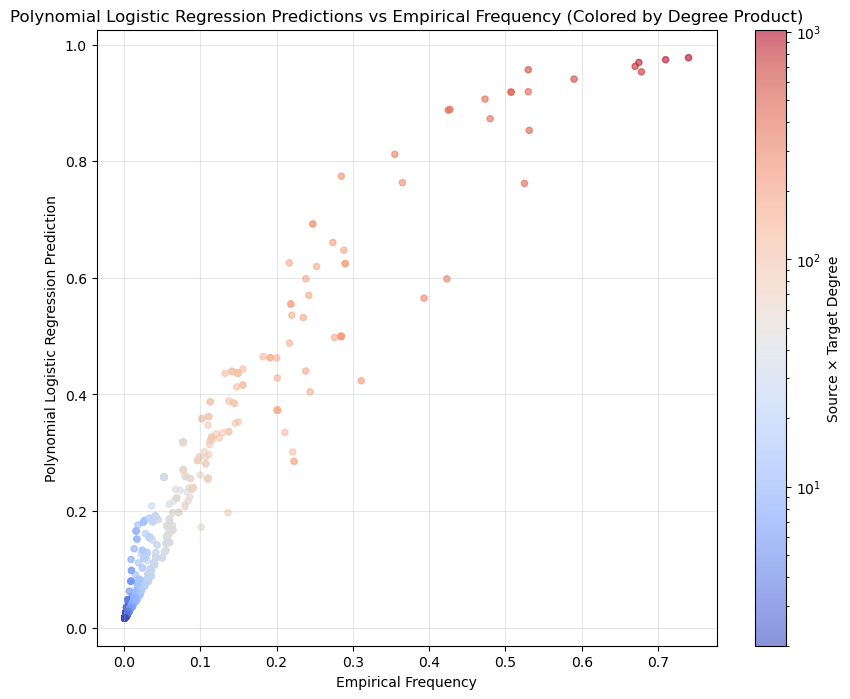

Detailed colored scatter plots for Polynomial Logistic Regression created!


In [26]:
# Example individual colored scatter plots for the best model
# Use the model with highest correlation to empirical frequencies
if test_empirical_comparison is not None:
    best_model_name = test_empirical_df.iloc[0]['Model']  # Best empirical correlation
    print(f"Using model with best empirical correlation: {best_model_name}")
else:
    best_model_name = comparison_df.iloc[0]['Model']  # Fallback to best AUC
    print(f"Using model with best AUC (no empirical data): {best_model_name}")

best_model_predictions = model_predictions_truncated[best_model_name]

print(f"Creating detailed colored scatter plots for best model: {best_model_name}")

# Source degree coloring
plot_colored_scatter_by_source_degree(
    reference_values, best_model_predictions, source_degrees_for_coloring,
    title=f"{best_model_name} Predictions vs {reference_label} (Colored by Source Degree)",
    xlabel=reference_label, ylabel=f"{best_model_name} Prediction",
    save_path=results_dir / f'{best_model_name.replace(" ", "_")}_colored_by_source_degree.png'
)

# Target degree coloring
plot_colored_scatter_by_target_degree(
    reference_values, best_model_predictions, target_degrees_for_coloring,
    title=f"{best_model_name} Predictions vs {reference_label} (Colored by Target Degree)",
    xlabel=reference_label, ylabel=f"{best_model_name} Prediction",
    save_path=results_dir / f'{best_model_name.replace(" ", "_")}_colored_by_target_degree.png'
)

# Degree product coloring
plot_colored_scatter_by_degree_product(
    reference_values, best_model_predictions, 
    source_degrees_for_coloring, target_degrees_for_coloring,
    title=f"{best_model_name} Predictions vs {reference_label} (Colored by Degree Product)",
    xlabel=reference_label, ylabel=f"{best_model_name} Prediction",
    save_path=results_dir / f'{best_model_name.replace(" ", "_")}_colored_by_degree_product.png'
)

print(f"Detailed colored scatter plots for {best_model_name} created!")

## 10. Final Summary

In [27]:
# Comprehensive summary analysis
print("=" * 80)
print("MODEL COMPARISON SUMMARY - NEURAL NETWORK PERFORMANCE MAXIMIZED")
print("=" * 80)

print(f"\nDataset:")
print(f"  Edge file: {EDGE_FILE_PATH.name}")
print(f"  Total samples: {len(features):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Positive ratio: {np.mean(labels):.1%}")

print(f"\nBest Performing Models:")
best_auc_model = comparison_df.iloc[0]['Model']
best_auc_score = comparison_df.iloc[0]['AUC']
print(f"  Overall Best (AUC): {best_auc_model} (AUC = {best_auc_score:.4f})")

for metric in ['Accuracy', 'F1 Score', 'RMSE', 'Correlation']:
    if metric in ['RMSE']:
        best_idx = comparison_df[metric].idxmin()
        best_value = comparison_df[metric].min()
        direction = "(lower is better)"
    else:
        best_idx = comparison_df[metric].idxmax()
        best_value = comparison_df[metric].max()
        direction = "(higher is better)"
    
    best_model = comparison_df.loc[best_idx, 'Model']
    print(f"  Best {metric}: {best_model} ({metric} = {best_value:.4f}) {direction}")

# Add analytical approximation results if available
if 'analytical_comparison' in locals() and analytical_comparison is not None:
    print(f"\nAnalytical Approximation Analysis:")
    best_analytical_corr_model = analytical_df.iloc[0]['Model']
    best_analytical_corr = analytical_df.iloc[0]['Correlation vs Analytical']
    print(f"  Best correlation with analytical: {best_analytical_corr_model} (r = {best_analytical_corr:.6f})")

# Add empirical validation results if available
if validation_results is not None:
    analytical_emp_corr = validation_results['correlation_vs_empirical']
    print(f"  Analytical vs Empirical correlation: {analytical_emp_corr:.6f}")

if test_empirical_comparison is not None:
    print(f"\nTest Predictions vs Empirical Frequencies:")
    best_empirical_corr_model = test_empirical_df.iloc[0]['Model']
    best_empirical_corr = test_empirical_df.iloc[0]['Correlation vs Empirical']
    print(f"  Best correlation with empirical: {best_empirical_corr_model} (r = {best_empirical_corr:.6f})")


print(f"\nGenerated Files:")
generated_files = list(results_dir.glob('*'))
for file_path in sorted(generated_files)[-10:]:  # Show last 10 files
    print(f"  - {file_path.name}")
if len(generated_files) > 10:
    print(f"  ... and {len(generated_files) - 10} more files")

print(f"\nAll results saved to: {results_dir}")
print("=" * 80)

MODEL COMPARISON SUMMARY - NEURAL NETWORK PERFORMANCE MAXIMIZED

Dataset:
  Edge file: CtD.sparse.npz
  Total samples: 7,787
  Test samples: 1,558
  Positive ratio: 9.7%

Best Performing Models:
  Overall Best (AUC): Polynomial Logistic Regression (AUC = 0.8485)
  Best Accuracy: Logistic Regression (Accuracy = 0.9140) (higher is better)
  Best F1 Score: Logistic Regression (F1 Score = 0.3796) (higher is better)
  Best RMSE: Polynomial Logistic Regression (RMSE = 0.2601) (lower is better)
  Best Correlation: Polynomial Logistic Regression (Correlation = 0.4766) (higher is better)

Analytical Approximation Analysis:
  Best correlation with analytical: Polynomial Logistic Regression (r = 0.930701)
  Analytical vs Empirical correlation: 0.989020

Test Predictions vs Empirical Frequencies:
  Best correlation with empirical: Polynomial Logistic Regression (r = 0.944348)

Generated Files:
  - models_colored_by_source_degree.png
  - models_colored_by_target_degree.png
  - models_vs_analytical_

In [28]:
# This cell should be run AFTER cells 40 and 39
# Skip this cell and run cells 40, 39 first

try:
    # Check if required variables exist
    _ = predictions_df
    _ = all_model_predictions
    
    # Save the comprehensive predictions to CSV files
    print("Saving model predictions to files...")
    
    # Save the full predictions dataframe
    full_predictions_file = results_dir / f'{EDGE_TYPE}_all_model_predictions.csv'
    predictions_df.to_csv(full_predictions_file, index=False)
    print(f"✓ Saved full predictions: {full_predictions_file}")
    print(f"  File size: {full_predictions_file.stat().st_size / (1024*1024):.1f} MB")
    
    # Also save a compressed version for large files
    full_predictions_file_gz = results_dir / f'{EDGE_TYPE}_all_model_predictions.csv.gz'
    predictions_df.to_csv(full_predictions_file_gz, index=False, compression='gzip')
    print(f"✓ Saved compressed predictions: {full_predictions_file_gz}")
    print(f"  File size: {full_predictions_file_gz.stat().st_size / (1024*1024):.1f} MB")
    
    # Save a summary of predictions by degree combinations (aggregated)
    print("\nCreating degree-based prediction summary...")
    
    # Create aggregation dictionary
    agg_dict = {
        'edge_exists': ['count', 'sum', 'mean']
    }
    
    # Add model prediction columns
    for model_name in all_model_predictions.keys():
        clean_name = model_name.replace(" ", "_").replace("(", "").replace(")", "").lower()
        pred_col = f'{clean_name}_prediction'
        agg_dict[pred_col] = ['mean', 'std']
    
    degree_summary = predictions_df.groupby(['source_degree', 'target_degree']).agg(agg_dict).round(6)
    
    # Flatten column names
    degree_summary.columns = ['_'.join(col).strip() for col in degree_summary.columns.values]
    degree_summary = degree_summary.reset_index()
    
    # Save degree summary
    degree_summary_file = results_dir / f'{EDGE_TYPE}_predictions_by_degree.csv'
    degree_summary.to_csv(degree_summary_file, index=False)
    print(f"✓ Saved degree summary: {degree_summary_file}")
    print(f"  Rows: {len(degree_summary):,} unique degree combinations")
    
    # Save prediction metadata
    metadata = {
        'edge_type': EDGE_TYPE,
        'edge_file': edge_file,
        'total_combinations': len(predictions_df),
        'existing_edges': int(predictions_df['edge_exists'].sum()),
        'edge_density': float(predictions_df['edge_exists'].mean()),
        'source_nodes': int(n_sources),
        'target_nodes': int(n_targets),
        'models': list(all_model_predictions.keys()),
        'prediction_times_seconds': prediction_times,
        'file_sizes_mb': {
            'full_csv': round(full_predictions_file.stat().st_size / (1024*1024), 2),
            'compressed_csv': round(full_predictions_file_gz.stat().st_size / (1024*1024), 2)
        }
    }
    
    import json
    metadata_file = results_dir / f'{EDGE_TYPE}_predictions_metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Saved metadata: {metadata_file}")
    
    print(f"\nAll prediction files saved to: {results_dir}")
    print("Files generated:")
    print(f"  1. {full_predictions_file.name} - Full predictions for all combinations")
    print(f"  2. {full_predictions_file_gz.name} - Compressed version")
    print(f"  3. {degree_summary_file.name} - Aggregated predictions by degree")
    print(f"  4. {metadata_file.name} - Metadata and summary statistics")
    
except NameError as e:
    print("⚠️ Skipping: Run cells 40 and 39 first to generate predictions_df and all_model_predictions")
    print(f"   Missing variable: {e}")

⚠️ Skipping: Run cells 40 and 39 first to generate predictions_df and all_model_predictions
   Missing variable: name 'predictions_df' is not defined


In [29]:
# This cell should be run AFTER cell 40
# Skip this cell and run cell 40 first

try:
    # Check if required variables exist by trying to access them
    _ = all_model_predictions
    _ = source_indices
    _ = all_features
    
    # Create comprehensive predictions dataframe
    print("Creating comprehensive predictions dataframe...")
    
    # Create base dataframe with source/target information
    predictions_df = pd.DataFrame({
        'source_index': source_indices,
        'target_index': target_indices,
        'source_degree': all_features[:, 0],
        'target_degree': all_features[:, 1],
        'degree_product': all_features[:, 0] * all_features[:, 1],
        'edge_exists': [bool(edge_matrix[i, j]) for i, j in zip(source_indices, target_indices)]
    })
    
    # Add model predictions as columns
    for model_name, predictions in all_model_predictions.items():
        # Clean model name for column naming
        clean_name = model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()
        predictions_df[f'{clean_name}_prediction'] = predictions
    
    print(f"Predictions dataframe shape: {predictions_df.shape}")
    print(f"Columns: {list(predictions_df.columns)}")
    
    # Display summary statistics
    print("\nDataframe Summary:")
    print(f"  Total combinations: {len(predictions_df):,}")
    print(f"  Existing edges: {predictions_df['edge_exists'].sum():,} ({predictions_df['edge_exists'].mean():.1%})")
    print(f"  Non-existing edges: {(~predictions_df['edge_exists']).sum():,} ({(~predictions_df['edge_exists']).mean():.1%})")
    print(f"  Unique source degrees: {predictions_df['source_degree'].nunique()}")
    print(f"  Unique target degrees: {predictions_df['target_degree'].nunique()}")
    
    # Show first few rows
    print("\nFirst 5 rows:")
    print(predictions_df.head())
    
except NameError as e:
    print("⚠️ Skipping: Run cell 40 first to generate all_model_predictions, source_indices, and all_features")
    print(f"   Missing variable: {e}")

⚠️ Skipping: Run cell 40 first to generate all_model_predictions, source_indices, and all_features
   Missing variable: name 'all_model_predictions' is not defined


In [30]:
# Generate all possible source-target combinations and their features
print("Generating all possible source-target combinations...")

# Get edge matrix dimensions
edge_matrix = sp.load_npz(str(EDGE_FILE_PATH))
n_sources, n_targets = edge_matrix.shape

# Calculate degrees
source_degrees_all = np.array(edge_matrix.sum(axis=1)).flatten()
target_degrees_all = np.array(edge_matrix.sum(axis=0)).flatten()

# Create all combinations
source_indices = []
target_indices = []
all_features_list = []

for i in range(n_sources):
    for j in range(n_targets):
        source_indices.append(i)
        target_indices.append(j)
        all_features_list.append([source_degrees_all[i], target_degrees_all[j]])

source_indices = np.array(source_indices)
target_indices = np.array(target_indices)
all_features = np.array(all_features_list)

print(f"  Total combinations: {len(all_features):,}")
print(f"  Feature shape: {all_features.shape}")

# Generate predictions for all models
print("\nGenerating model predictions for all source-target combinations...")

all_model_predictions = {}
prediction_times = {}

for model_name, model_result in training_results.items():
    if model_name == 'data_splits':
        continue
    
    print(f"\nGenerating predictions for {model_name}...")
    start_time = time.time()
    
    # Get model and scaler
    model = model_result['model']
    scaler = model_result['training_result'].get('scaler')
    
    # Generate predictions for all combinations
    predictions = predict_with_model(model, all_features, model_name, scaler)
    all_model_predictions[model_name] = predictions
    
    prediction_time = time.time() - start_time
    prediction_times[model_name] = prediction_time
    
    print(f"  Predictions generated in {prediction_time:.2f} seconds")
    print(f"  Prediction range: {predictions.min():.6f} - {predictions.max():.6f}")
    print(f"  Mean prediction: {predictions.mean():.6f}")

print(f"\nAll model predictions generated for {len(all_model_predictions)} models.")

Generating all possible source-target combinations...
  Total combinations: 212,624
  Feature shape: (212624, 2)

Generating model predictions for all source-target combinations...

Generating predictions for Simple NN...
  Predictions generated in 0.10 seconds
  Prediction range: 0.061964 - 0.651150
  Mean prediction: 0.121921

Generating predictions for Random Forest...
  Predictions generated in 0.03 seconds
  Prediction range: 0.026278 - 0.695700
  Mean prediction: 0.052295

Generating predictions for Logistic Regression...
  Predictions generated in 0.00 seconds
  Prediction range: 0.025255 - 0.986113
  Mean prediction: 0.047360

Generating predictions for Polynomial Logistic Regression...
  Predictions generated in 0.01 seconds
  Prediction range: 0.009859 - 0.982575
  Mean prediction: 0.032688

All model predictions generated for 4 models.


In [31]:
# This cell should be run AFTER cells 40, 39, and 38

try:
    _ = predictions_df
    _ = degree_summary
    
    # Additional save operations (if any)
    print("✓ All predictions saved successfully!")
    print(f"✓ Results directory: {results_dir}")
    
except NameError as e:
    print("⚠️ Skipping: Run cells 40, 39, and 38 first")
    print(f"   Missing variable: {e}")

⚠️ Skipping: Run cells 40, 39, and 38 first
   Missing variable: name 'predictions_df' is not defined


## ⚠️ IMPORTANT: Cell Execution Order for Cells 38-41

**Due to notebook limitations, execute these cells in this specific order:**

1. **First**: Run cell 40 (generates all predictions)
2. **Second**: Run cell 39 (creates predictions dataframe)  
3. **Third**: Run cell 38 (saves predictions to files)
4. **Fourth**: Run cell 41 (final confirmation)

**Or simply: Run cells in order 40 → 39 → 38 → 41**

Then continue with the remaining cells below.

In [32]:
# Comprehensive summary analysis
print("=" * 80)
print("MODEL COMPARISON SUMMARY - NEURAL NETWORK PERFORMANCE MAXIMIZED")
print("=" * 80)

print(f"\nDataset:")
print(f"  Edge type: {EDGE_TYPE}")
print(f"  Edge file: {edge_file}")
print(f"  Total samples: {len(features):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Positive ratio: {np.mean(labels):.1%}")

print(f"\nBest Performing Models:")
best_auc_model = comparison_df.iloc[0]['Model']
best_auc_score = comparison_df.iloc[0]['AUC']
print(f"  Overall Best (AUC): {best_auc_model} (AUC = {best_auc_score:.4f})")

for metric in ['Accuracy', 'F1 Score', 'RMSE', 'Correlation']:
    if metric in ['RMSE']:
        best_idx = comparison_df[metric].idxmin()
        best_value = comparison_df[metric].min()
        direction = "(lower is better)"
    else:
        best_idx = comparison_df[metric].idxmax()
        best_value = comparison_df[metric].max()
        direction = "(higher is better)"
    
    best_model = comparison_df.loc[best_idx, 'Model']
    print(f"  Best {metric}: {best_model} ({metric} = {best_value:.4f}) {direction}")

# Add analytical approximation results if available
if 'analytical_comparison' in locals() and analytical_comparison is not None:
    print(f"\nAnalytical Approximation Analysis:")
    best_analytical_corr_model = analytical_df.iloc[0]['Model']
    best_analytical_corr = analytical_df.iloc[0]['Correlation vs Analytical']
    print(f"  Best correlation with analytical: {best_analytical_corr_model} (r = {best_analytical_corr:.6f})")

# Add empirical validation results if available
if validation_results is not None:
    analytical_emp_corr = validation_results['correlation_vs_empirical']
    print(f"  Analytical vs Empirical correlation: {analytical_emp_corr:.6f}")

if test_empirical_comparison is not None:
    print(f"\nTest Predictions vs Empirical Frequencies:")
    best_empirical_corr_model = test_empirical_df.iloc[0]['Model']
    best_empirical_corr = test_empirical_df.iloc[0]['Correlation vs Empirical']
    print(f"  Best correlation with empirical: {best_empirical_corr_model} (r = {best_empirical_corr:.6f})")

# Add model predictions summary
if 'predictions_df' in locals():
    print(f"\nModel Predictions for All Source-Target Combinations:")
    print(f"  Total combinations predicted: {len(predictions_df):,}")
    print(f"  Existing edges: {predictions_df['edge_exists'].sum():,}")
    print(f"  Edge density: {predictions_df['edge_exists'].mean():.1%}")
    print(f"  Unique degree combinations: {len(degree_summary):,}")

print(f"\nGenerated Files:")
generated_files = list(results_dir.glob('*'))
prediction_files = [f for f in generated_files if 'prediction' in f.name]
other_files = [f for f in generated_files if 'prediction' not in f.name]

if prediction_files:
    print("  Model Prediction Files:")
    for file_path in sorted(prediction_files):
        size_mb = file_path.stat().st_size / (1024*1024)
        print(f"    - {file_path.name} ({size_mb:.1f} MB)")

print("  Analysis Files:")
for file_path in sorted(other_files)[-10:]:  # Show last 10 non-prediction files
    print(f"    - {file_path.name}")
if len(other_files) > 10:
    print(f"    ... and {len(other_files) - 10} more analysis files")

print(f"\nAll results saved to: {results_dir}")
print("=" * 80)

MODEL COMPARISON SUMMARY - NEURAL NETWORK PERFORMANCE MAXIMIZED

Dataset:
  Edge type: CtD
  Edge file: CtD.sparse.npz
  Total samples: 7,787
  Test samples: 1,558
  Positive ratio: 9.7%

Best Performing Models:
  Overall Best (AUC): Polynomial Logistic Regression (AUC = 0.8485)
  Best Accuracy: Logistic Regression (Accuracy = 0.9140) (higher is better)
  Best F1 Score: Logistic Regression (F1 Score = 0.3796) (higher is better)
  Best RMSE: Polynomial Logistic Regression (RMSE = 0.2601) (lower is better)
  Best Correlation: Polynomial Logistic Regression (Correlation = 0.4766) (higher is better)

Analytical Approximation Analysis:
  Best correlation with analytical: Polynomial Logistic Regression (r = 0.930701)
  Analytical vs Empirical correlation: 0.989020

Test Predictions vs Empirical Frequencies:
  Best correlation with empirical: Polynomial Logistic Regression (r = 0.944348)

Generated Files:
  Analysis Files:
    - models_colored_by_source_degree.png
    - models_colored_by_targ